# Начало

In [1]:
import numpy as np

## Исходные функции

In [2]:
# путь до данных на компьютере
path = 'train_data/'

In [ ]:
# для работающих в Google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import os
import pandas as pd
import tqdm


def read_parquet_dataset_from_local(path_to_dataset: str, start_from: int = 0,
                                     num_parts_to_read: int = 2, columns=None, verbose=False) -> pd.DataFrame:
    """
    читает num_parts_to_read партиций, преобразовывает их к pd.DataFrame и возвращает
    :param path_to_dataset: путь до директории с партициями
    :param start_from: номер партиции, с которой нужно начать чтение
    :param num_parts_to_read: количество партиций, которые требуется прочитать
    :param columns: список колонок, которые нужно прочитать из партиции
    :return: pd.DataFrame
    """

    res = []
    dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset)
                              if filename.startswith('train')])
    print(dataset_paths)

    start_from = max(0, start_from)
    chunks = dataset_paths[start_from: start_from + num_parts_to_read]
    if verbose:
        print('Reading chunks:\n')
        for chunk in chunks:
            print(chunk)
    for chunk_path in tqdm.notebook.tqdm(chunks, desc="Reading dataset with pandas"):
        print('chunk_path', chunk_path)
        chunk = pd.read_parquet(chunk_path,columns=columns)
        res.append(chunk)

    return pd.concat(res).reset_index(drop=True)

In [13]:
def prepare_transactions_dataset(path_to_dataset: str, num_parts_to_preprocess_at_once: int = 1, num_parts_total: int=50,
                                 save_to_path=None, verbose: bool=False):
    """
    возвращает готовый pd.DataFrame с признаками, на которых можно учить модель для целевой задачи
    path_to_dataset: str
        путь до датасета с партициями
    num_parts_to_preprocess_at_once: int
        количество партиций, которые будут одновременно держаться и обрабатываться в памяти
    num_parts_total: int
        общее количество партиций, которые нужно обработать
    save_to_path: str
        путь до папки, в которой будет сохранён каждый обработанный блок в .parquet-формате; если None, то не будет сохранён
    verbose: bool
        логирует каждую обрабатываемую часть данных
    """
    preprocessed_frames = []

    for step in tqdm.tqdm_notebook(range(0, num_parts_total, num_parts_to_preprocess_at_once),
                                   desc="Transforming transactions data"):
        transactions_frame = read_parquet_dataset_from_local(path_to_dataset, step, num_parts_to_preprocess_at_once,
                                                             verbose=verbose)


   #здесь должен быть препроцессинг данных


   #записываем подготовленные данные в файл
        if save_to_path:
            block_as_str = str(step)
            if len(block_as_str) == 1:
                block_as_str = '00' + block_as_str
            else:
                block_as_str = '0' + block_as_str
            transactions_frame.to_parquet(os.path.join(save_to_path, f'processed_chunk_{block_as_str}.parquet'))

        preprocessed_frames.append(transactions_frame)
    return pd.concat(preprocessed_frames)

## Дополнительные функции

In [5]:
from IPython.display import display
import missingno as msno
import matplotlib.pyplot as plt

def print_data_info(df):
    display('=== data.shape ===',df.shape)
    
    display(df.info())
    print('='*80)
    
    data_info = df.describe().T
    display(data_info[:50])
    display(data_info[50:])
    print('='*80)
    
    msno.bar(df)
    

In [7]:
# пока этот вариант проверим
def prepare_transactions_dataset(path_to_dataset: str, num_parts_to_preprocess_at_once: int = 1, num_parts_total: int=50,
                                 save_to_path=None, verbose: bool=False):
    """
    возвращает готовый pd.DataFrame с признаками, на которых можно учить модель для целевой задачи
    path_to_dataset: str
        путь до датасета с партициями
    num_parts_to_preprocess_at_once: int
        количество партиций, которые будут одновременно держаться и обрабатываться в памяти
    num_parts_total: int
        общее количество партиций, которые нужно обработать
    save_to_path: str
        путь до папки, в которой будет сохранён каждый обработанный блок в .parquet-формате; если None, то не будет сохранён
    verbose: bool
        логирует каждую обрабатываемую часть данных
    """
    preprocessed_frames = []

    for step in tqdm.notebook.tqdm(range(0, num_parts_total, num_parts_to_preprocess_at_once),
                                   desc="Transforming transactions data"):
        transactions_frame = read_parquet_dataset_from_local(path_to_dataset, step, num_parts_to_preprocess_at_once,
                                                             verbose=verbose)
        #здесь должен быть препроцессинг данных
        columns = list(transactions_frame.columns)
        columns.remove('id')

        for column in columns:
            transactions_frame[column] = transactions_frame[column].astype(np.int8)



        #записываем подготовленные данные в файл
        if save_to_path:
            block_as_str = str(step)
            if len(block_as_str) == 1:
                block_as_str = '00' + block_as_str
            else:
                block_as_str = '0' + block_as_str
            transactions_frame.to_parquet(os.path.join(save_to_path, f'processed_chunk_{block_as_str}.parquet'))

        preprocessed_frames.append(transactions_frame)
    return pd.concat(preprocessed_frames)

# Чтение данных

## target

In [7]:
# значения целевой переменной (смерджить с фичами по id)
targets = pd.read_csv('train_target.csv')
targets.head()

,id,flag
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [41]:
targets.shape

(3000000, 2)

## Чтение 0 - 1

In [5]:
data = prepare_transactions_dataset(path, num_parts_to_preprocess_at_once=2, num_parts_total=2,
                                    save_to_path='train_data/')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_32300\2668831860.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm.tqdm_notebook(range(0, num_parts_total, num_parts_to_preprocess_at_once),


Transforming transactions data:   0%|          | 0/1 [00:00<?, ?it/s]

['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_32300\3059785415.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

chunk_path train_data/train_data_0.pq
chunk_path train_data/train_data_1.pq


In [6]:
# пример полученных данных
c.head()

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
0,0,1,18,9,2,3,16,10,11,3,...,3,3,3,4,1,3,4,1,0,0
1,0,2,18,9,14,14,12,12,0,3,...,0,0,0,4,1,3,4,1,0,0
2,0,3,18,9,4,8,1,11,11,0,...,0,0,0,4,1,2,3,1,1,1
3,0,4,4,1,9,12,16,7,12,2,...,3,3,3,4,1,3,1,1,0,0
4,0,5,5,12,15,2,11,12,10,2,...,3,3,3,4,1,3,4,1,0,0


In [8]:
targets.shape

(3000000, 2)

In [9]:
data.shape

(4082029, 61)

## Чтение 10 - 11

['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']
Reading chunks:

train_data/train_data_10.pq
train_data/train_data_11.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

chunk_path train_data/train_data_10.pq
chunk_path train_data/train_data_11.pq


'=== data.shape ==='

(4747002, 61)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4747002 entries, 0 to 4747001
Data columns (total 61 columns):
 #   Column                         Dtype
---  ------                         -----
 0   id                             int64
 1   rn                             int64
 2   pre_since_opened               int64
 3   pre_since_confirmed            int64
 4   pre_pterm                      int64
 5   pre_fterm                      int64
 6   pre_till_pclose                int64
 7   pre_till_fclose                int64
 8   pre_loans_credit_limit         int64
 9   pre_loans_next_pay_summ        int64
 10  pre_loans_outstanding          int64
 11  pre_loans_total_overdue        int64
 12  pre_loans_max_overdue_sum      int64
 13  pre_loans_credit_cost_rate     int64
 14  pre_loans5                     int64
 15  pre_loans530                   int64
 16  pre_loans3060                  int64
 17  pre_loans6090                  int64
 18  pre_loans90                    int64
 19  

None

,count,mean,std,min,25%,50%,75%,max
id,4747002.0,2.753015e+06,143477.549112,2500000.0,2629172.0,2758409.0,2875198.0,2999999.0
rn,4747002.0,7.429920e+00,5.569519,1.0,3.0,6.0,11.0,58.0
pre_since_opened,4747002.0,9.539647e+00,5.832933,0.0,4.0,10.0,15.0,19.0
pre_since_confirmed,4747002.0,8.666966e+00,4.855755,0.0,5.0,9.0,12.0,17.0
pre_pterm,4747002.0,8.361286e+00,5.330289,0.0,4.0,8.0,14.0,17.0
pre_fterm,4747002.0,8.320328e+00,4.529352,0.0,6.0,8.0,12.0,16.0
pre_till_pclose,4747002.0,7.109846e+00,5.138302,0.0,2.0,7.0,12.0,16.0
pre_till_fclose,4747002.0,8.333270e+00,4.242966,0.0,5.0,10.0,11.0,15.0
pre_loans_credit_limit,4747002.0,9.582437e+00,5.850500,0.0,4.0,10.0,14.0,19.0
pre_loans_next_pay_summ,4747002.0,2.352722e+00,1.281068,0.0,2.0,2.0,2.0,6.0


,count,mean,std,min,25%,50%,75%,max
enc_paym_20,4747002.0,3.258822,1.281184,1.0,2.0,4.0,4.0,4.0
enc_paym_21,4747002.0,2.294203,1.260133,0.0,3.0,3.0,3.0,3.0
enc_paym_22,4747002.0,2.327978,1.238837,0.0,3.0,3.0,3.0,3.0
enc_paym_23,4747002.0,2.363618,1.214953,0.0,3.0,3.0,3.0,3.0
enc_paym_24,4747002.0,3.506289,1.102508,1.0,4.0,4.0,4.0,4.0
enc_loans_account_holder_type,4747002.0,1.038463,0.323313,0.0,1.0,1.0,1.0,6.0
enc_loans_credit_status,4747002.0,2.692113,0.493374,0.0,2.0,3.0,3.0,6.0
enc_loans_credit_type,4747002.0,3.635701,1.052501,0.0,3.0,4.0,4.0,7.0
enc_loans_account_cur,4747002.0,1.001366,0.043358,0.0,1.0,1.0,1.0,3.0
pclose_flag,4747002.0,0.151420,0.358457,0.0,0.0,0.0,0.0,1.0


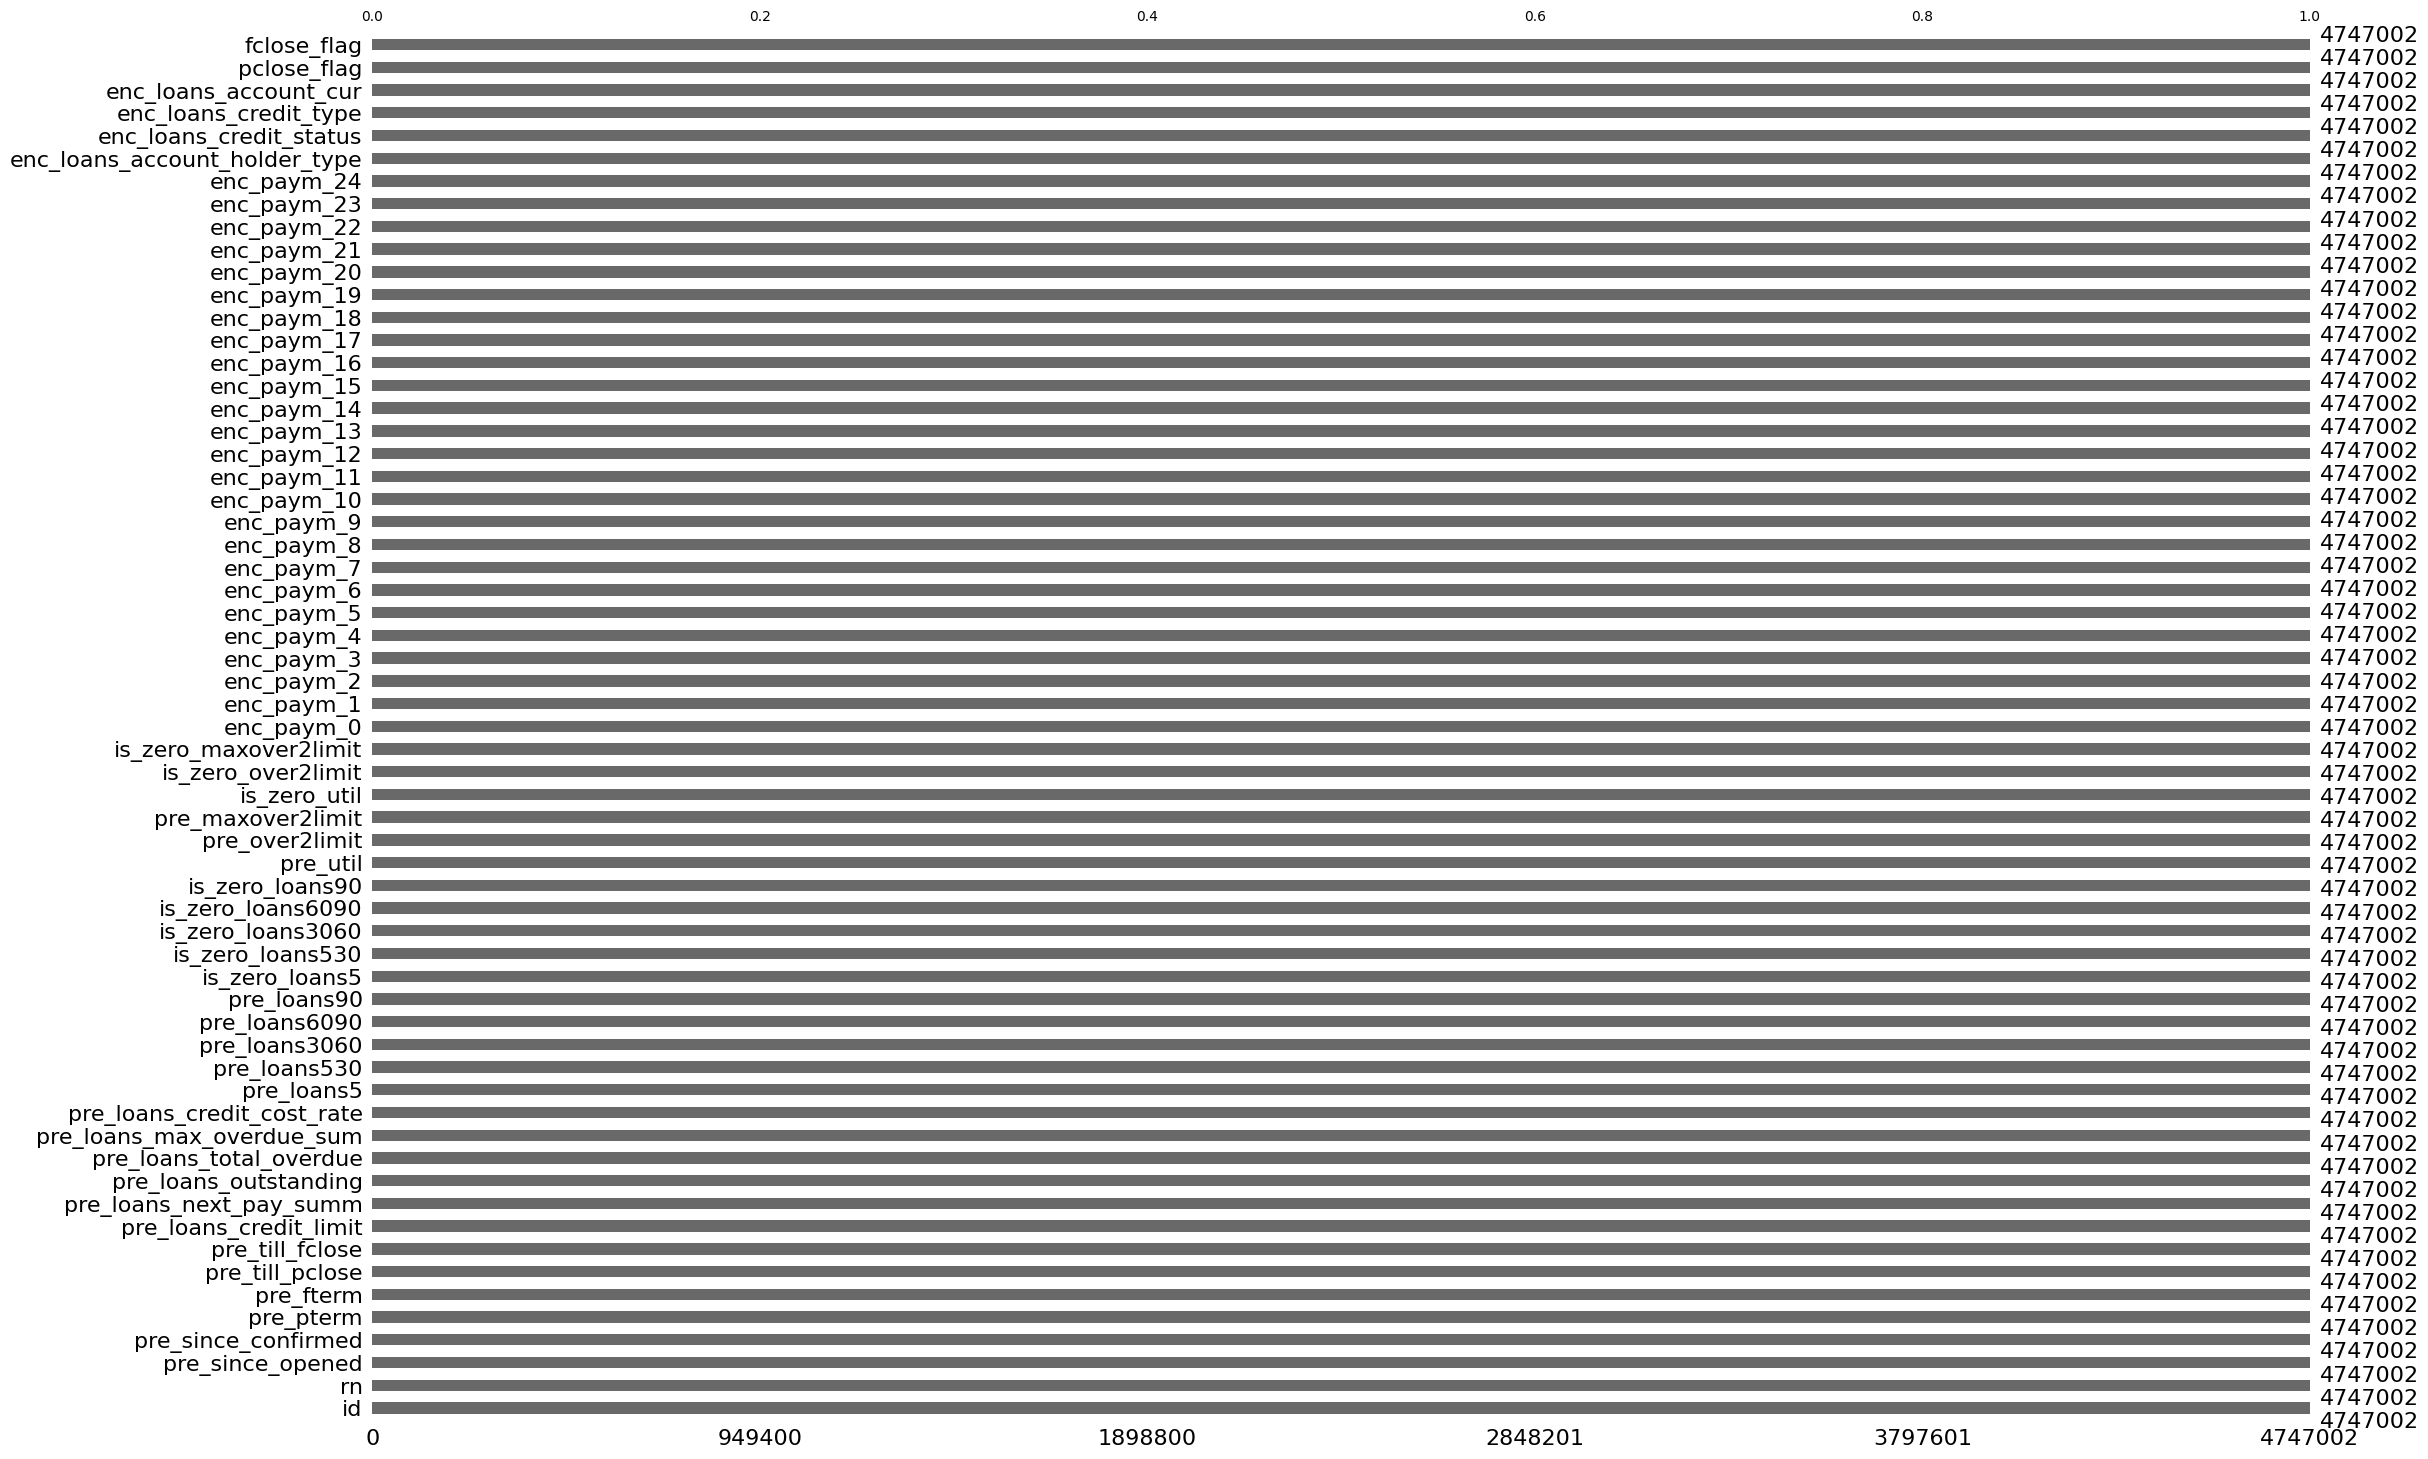

In [56]:
data = read_parquet_dataset_from_local(path, start_from=2, num_parts_to_read=2, verbose=True)
print_data_info(data)

## 2 - 3

In [48]:
data = read_parquet_dataset_from_local(path, start_from=4, num_parts_to_read=2, verbose=True)

['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']
Reading chunks:

train_data/train_data_2.pq
train_data/train_data_3.pq


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_32300\3059785415.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

chunk_path train_data/train_data_2.pq
chunk_path train_data/train_data_3.pq


'=== data.shape ==='

(4193100, 61)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4193100 entries, 0 to 4193099
Data columns (total 61 columns):
 #   Column                         Dtype
---  ------                         -----
 0   id                             int64
 1   rn                             int64
 2   pre_since_opened               int64
 3   pre_since_confirmed            int64
 4   pre_pterm                      int64
 5   pre_fterm                      int64
 6   pre_till_pclose                int64
 7   pre_till_fclose                int64
 8   pre_loans_credit_limit         int64
 9   pre_loans_next_pay_summ        int64
 10  pre_loans_outstanding          int64
 11  pre_loans_total_overdue        int64
 12  pre_loans_max_overdue_sum      int64
 13  pre_loans_credit_cost_rate     int64
 14  pre_loans5                     int64
 15  pre_loans530                   int64
 16  pre_loans3060                  int64
 17  pre_loans6090                  int64
 18  pre_loans90                    int64
 19  

None

,count,mean,std,min,25%,50%,75%,max
id,4193100.0,750961.393970,144402.317552,500000.0,625977.0,751986.0,876125.0,999999.0
rn,4193100.0,6.817296,5.269848,1.0,3.0,5.0,10.0,51.0
pre_since_opened,4193100.0,9.286136,5.767455,0.0,5.0,9.0,14.0,19.0
pre_since_confirmed,4193100.0,8.336230,4.621824,0.0,5.0,9.0,12.0,17.0
pre_pterm,4193100.0,8.387299,5.324562,0.0,4.0,8.0,14.0,17.0
pre_fterm,4193100.0,8.282716,4.432689,0.0,6.0,8.0,11.0,16.0
pre_till_pclose,4193100.0,7.224657,5.168840,0.0,2.0,7.0,12.0,16.0
pre_till_fclose,4193100.0,8.404432,4.203617,0.0,5.0,10.0,11.0,15.0
pre_loans_credit_limit,4193100.0,9.738865,5.812769,0.0,5.0,10.0,15.0,19.0
pre_loans_next_pay_summ,4193100.0,2.378897,1.336977,0.0,2.0,2.0,2.0,6.0


,count,mean,std,min,25%,50%,75%,max
enc_paym_20,4193100.0,3.293601,1.260177,1.0,4.0,4.0,4.0,4.0
enc_paym_21,4193100.0,2.323340,1.241502,0.0,3.0,3.0,3.0,3.0
enc_paym_22,4193100.0,2.352948,1.221943,0.0,3.0,3.0,3.0,3.0
enc_paym_23,4193100.0,2.385763,1.199047,0.0,3.0,3.0,3.0,3.0
enc_paym_24,4193100.0,3.538175,1.073364,1.0,4.0,4.0,4.0,4.0
enc_loans_account_holder_type,4193100.0,1.032703,0.299470,0.0,1.0,1.0,1.0,6.0
enc_loans_credit_status,4193100.0,2.686647,0.495483,0.0,2.0,3.0,3.0,6.0
enc_loans_credit_type,4193100.0,3.359770,1.063527,0.0,3.0,4.0,4.0,5.0
enc_loans_account_cur,4193100.0,1.001893,0.051520,0.0,1.0,1.0,1.0,3.0
pclose_flag,4193100.0,0.144647,0.351745,0.0,0.0,0.0,0.0,1.0


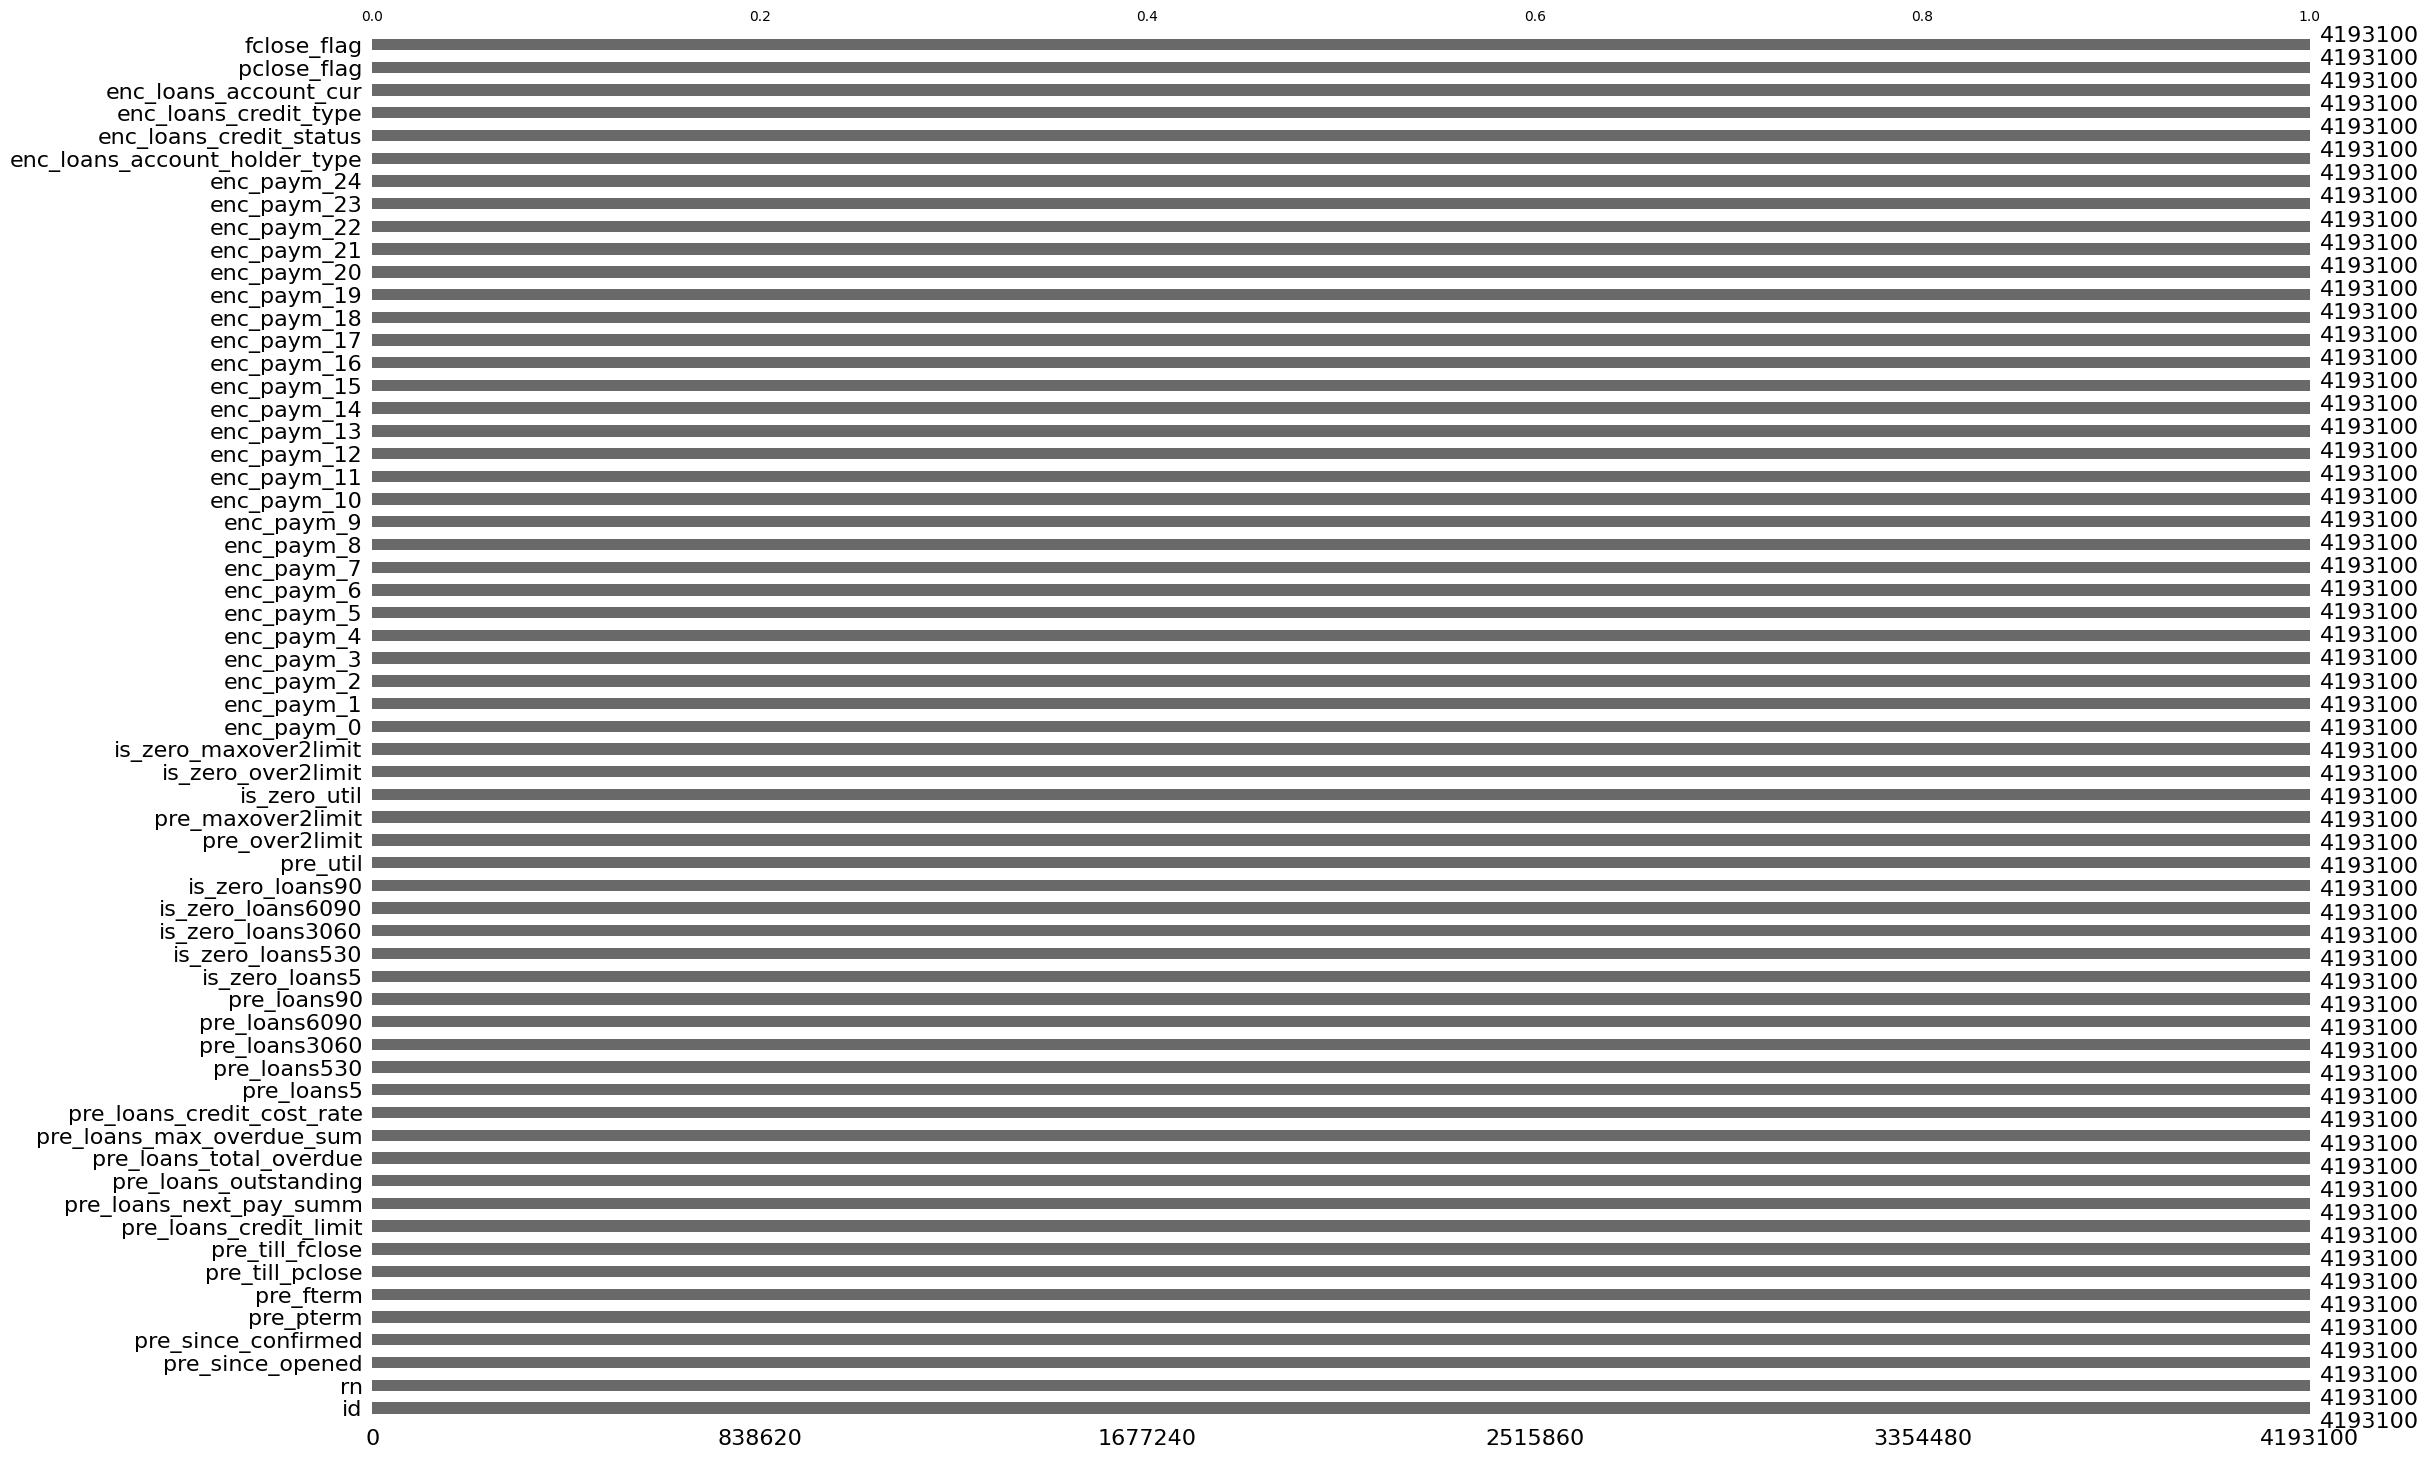

In [50]:
print_data_info(data)

## 4 - 5

['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']
Reading chunks:

train_data/train_data_4.pq
train_data/train_data_5.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

chunk_path train_data/train_data_4.pq
chunk_path train_data/train_data_5.pq


'=== data.shape ==='

(4215018, 61)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4215018 entries, 0 to 4215017
Data columns (total 61 columns):
 #   Column                         Dtype
---  ------                         -----
 0   id                             int64
 1   rn                             int64
 2   pre_since_opened               int64
 3   pre_since_confirmed            int64
 4   pre_pterm                      int64
 5   pre_fterm                      int64
 6   pre_till_pclose                int64
 7   pre_till_fclose                int64
 8   pre_loans_credit_limit         int64
 9   pre_loans_next_pay_summ        int64
 10  pre_loans_outstanding          int64
 11  pre_loans_total_overdue        int64
 12  pre_loans_max_overdue_sum      int64
 13  pre_loans_credit_cost_rate     int64
 14  pre_loans5                     int64
 15  pre_loans530                   int64
 16  pre_loans3060                  int64
 17  pre_loans6090                  int64
 18  pre_loans90                    int64
 19  

None

,count,mean,std,min,25%,50%,75%,max
id,4215018.0,1.253039e+06,144982.311152,1000000.0,1126971.25,1255170.0,1379108.75,1499999.0
rn,4215018.0,6.942710e+00,5.352268,1.0,3.00,6.0,10.00,47.0
pre_since_opened,4215018.0,9.318059e+00,5.757131,0.0,5.00,9.0,14.00,19.0
pre_since_confirmed,4215018.0,7.691783e+00,4.694746,0.0,4.00,8.0,11.00,17.0
pre_pterm,4215018.0,8.352216e+00,5.324116,0.0,4.00,8.0,14.00,17.0
pre_fterm,4215018.0,8.366175e+00,4.458703,0.0,6.00,8.0,12.00,16.0
pre_till_pclose,4215018.0,7.124207e+00,5.163389,0.0,2.00,7.0,12.00,16.0
pre_till_fclose,4215018.0,8.374670e+00,4.209549,0.0,5.00,10.0,11.00,15.0
pre_loans_credit_limit,4215018.0,9.729443e+00,5.821874,0.0,5.00,10.0,15.00,19.0
pre_loans_next_pay_summ,4215018.0,2.363234e+00,1.316347,0.0,2.00,2.0,2.00,6.0


,count,mean,std,min,25%,50%,75%,max
enc_paym_20,4215018.0,3.309524,1.249169,1.0,4.0,4.0,4.0,4.0
enc_paym_21,4215018.0,2.339431,1.229975,0.0,3.0,3.0,3.0,3.0
enc_paym_22,4215018.0,2.368697,1.210200,0.0,3.0,3.0,3.0,3.0
enc_paym_23,4215018.0,2.399080,1.188635,0.0,3.0,3.0,3.0,3.0
enc_paym_24,4215018.0,3.541295,1.069650,1.0,4.0,4.0,4.0,4.0
enc_loans_account_holder_type,4215018.0,1.033617,0.304066,0.0,1.0,1.0,1.0,6.0
enc_loans_credit_status,4215018.0,2.695539,0.516232,0.0,2.0,3.0,3.0,6.0
enc_loans_credit_type,4215018.0,3.524939,0.955849,0.0,3.0,4.0,4.0,7.0
enc_loans_account_cur,4215018.0,1.001708,0.048826,0.0,1.0,1.0,1.0,3.0
pclose_flag,4215018.0,0.151371,0.358410,0.0,0.0,0.0,0.0,1.0


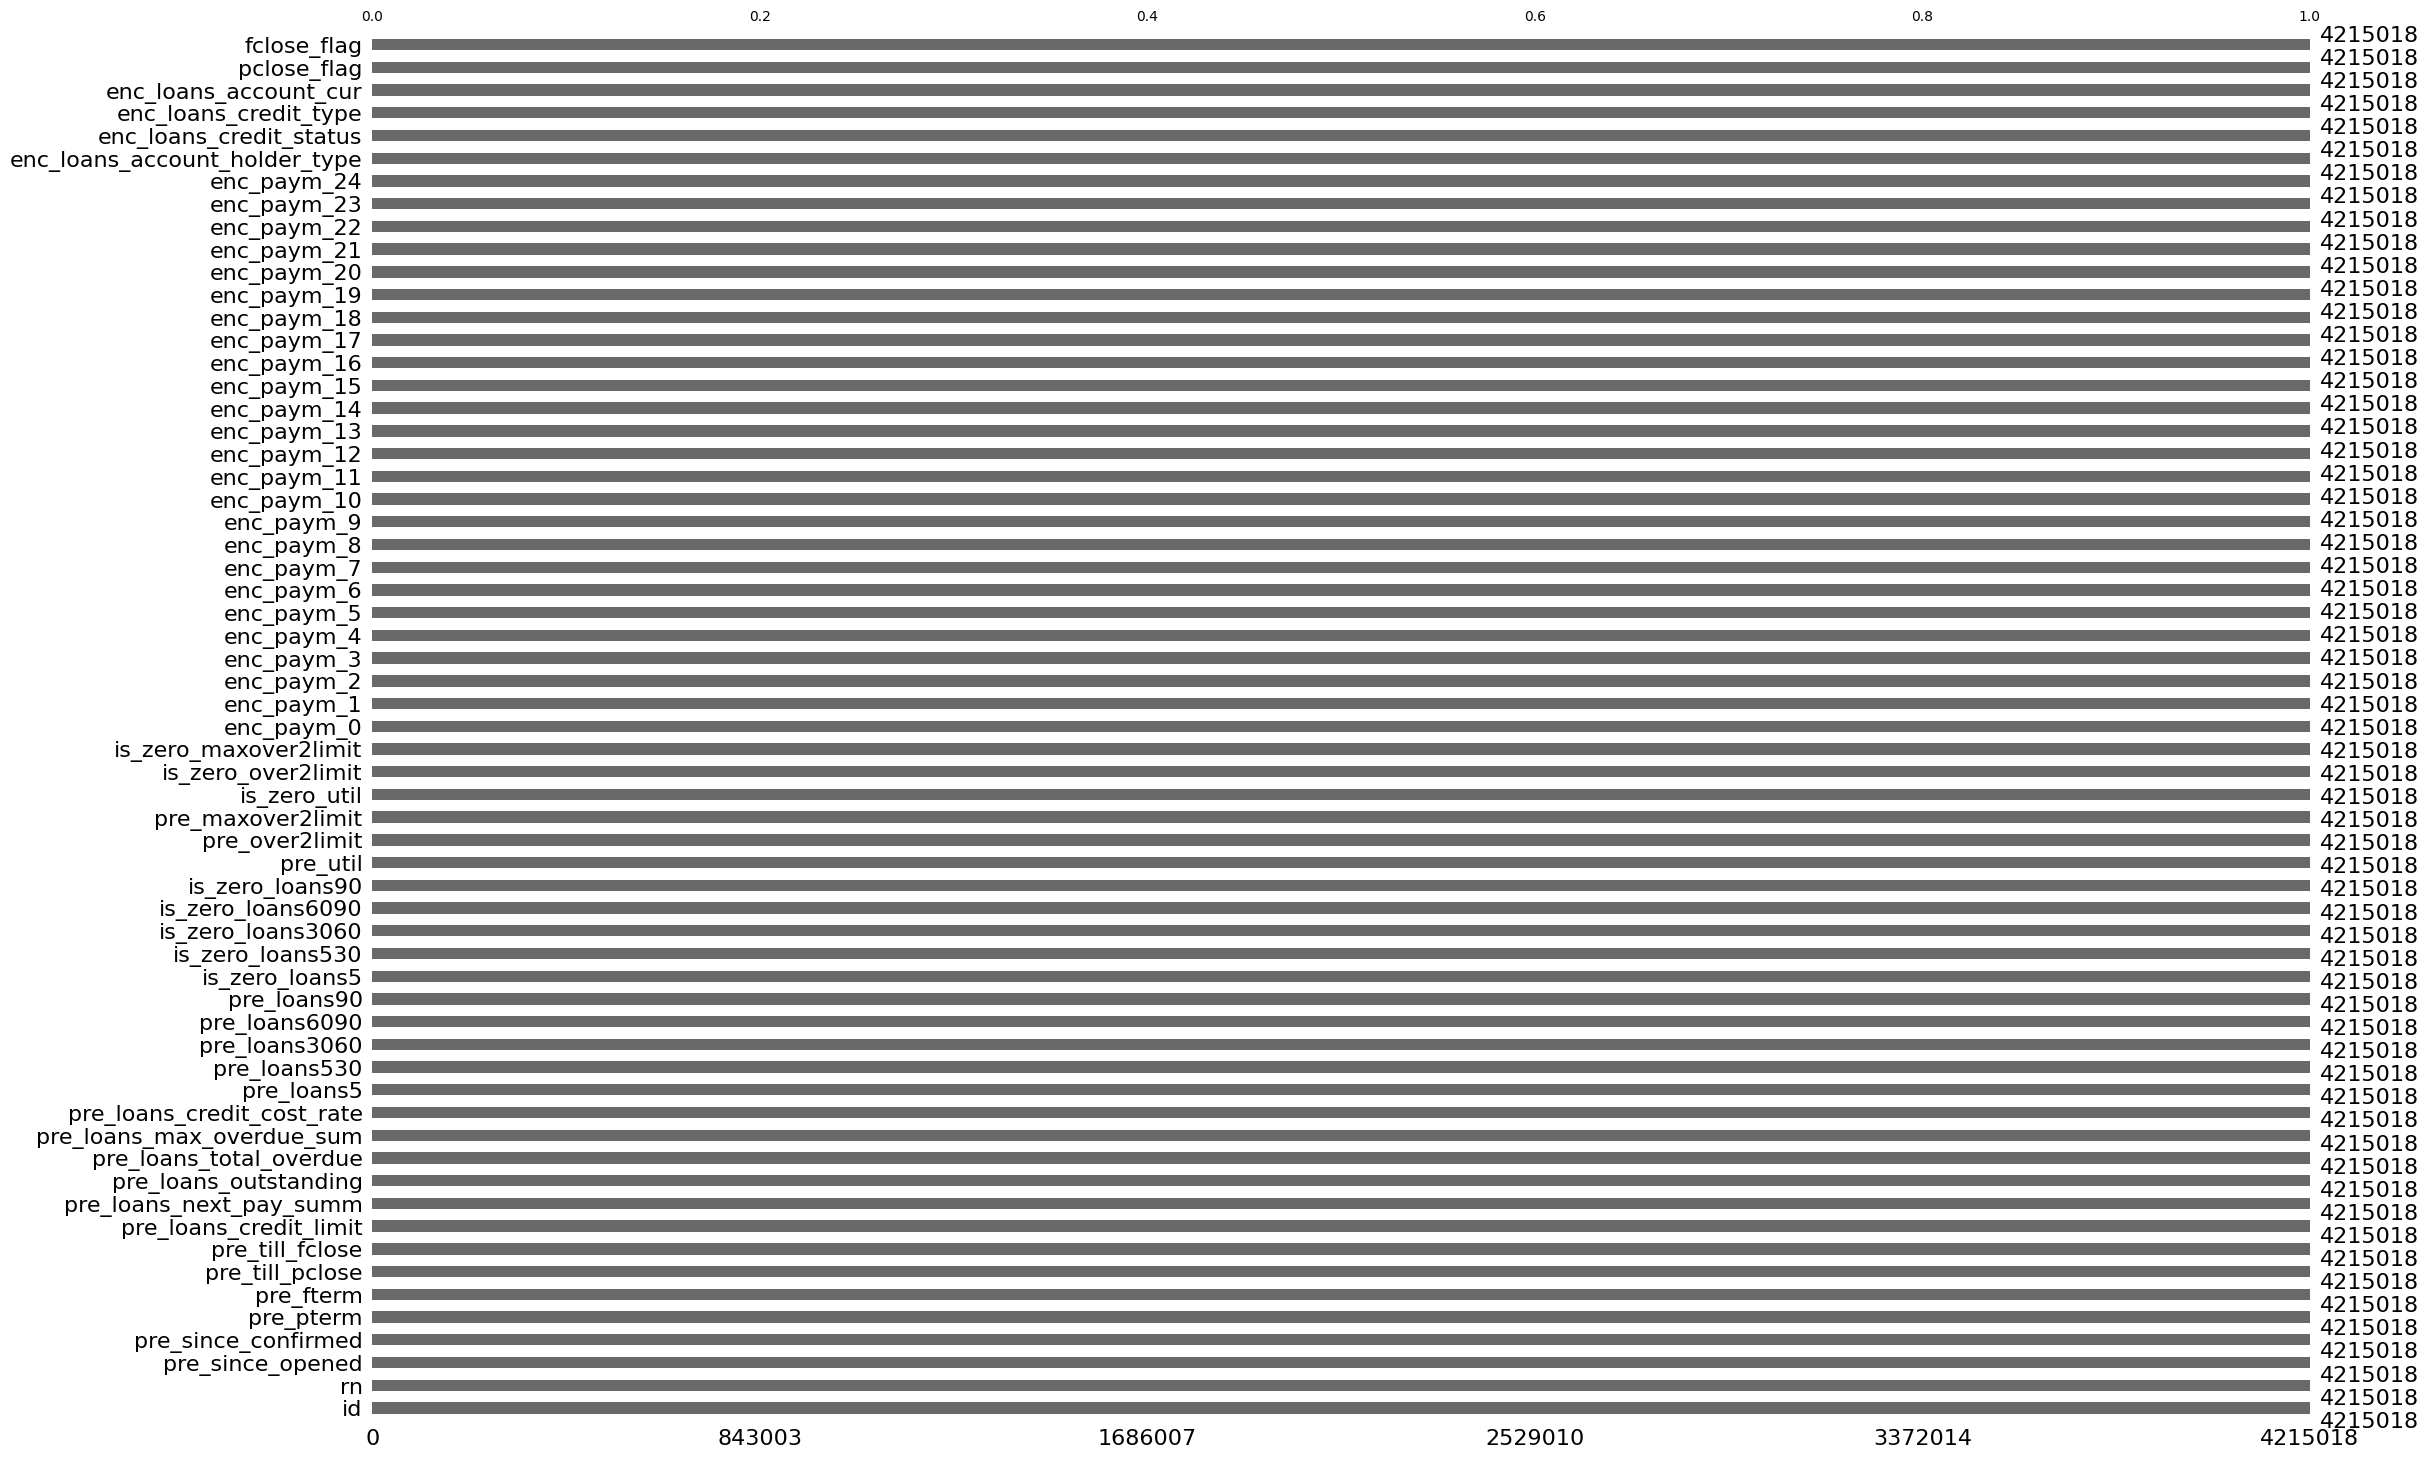

In [52]:
data = read_parquet_dataset_from_local(path, start_from=6, num_parts_to_read=2, verbose=True)
print_data_info(data)

## 6 - 7

['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']
Reading chunks:

train_data/train_data_6.pq
train_data/train_data_7.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

chunk_path train_data/train_data_6.pq
chunk_path train_data/train_data_7.pq


'=== data.shape ==='

(4398697, 61)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398697 entries, 0 to 4398696
Data columns (total 61 columns):
 #   Column                         Dtype
---  ------                         -----
 0   id                             int64
 1   rn                             int64
 2   pre_since_opened               int64
 3   pre_since_confirmed            int64
 4   pre_pterm                      int64
 5   pre_fterm                      int64
 6   pre_till_pclose                int64
 7   pre_till_fclose                int64
 8   pre_loans_credit_limit         int64
 9   pre_loans_next_pay_summ        int64
 10  pre_loans_outstanding          int64
 11  pre_loans_total_overdue        int64
 12  pre_loans_max_overdue_sum      int64
 13  pre_loans_credit_cost_rate     int64
 14  pre_loans5                     int64
 15  pre_loans530                   int64
 16  pre_loans3060                  int64
 17  pre_loans6090                  int64
 18  pre_loans90                    int64
 19  

None

,count,mean,std,min,25%,50%,75%,max
id,4398697.0,1.751598e+06,144130.347977,1500000.0,1627544.0,1752676.0,1876611.0,1999999.0
rn,4398697.0,7.101723e+00,5.415055,1.0,3.0,6.0,10.0,55.0
pre_since_opened,4398697.0,9.319304e+00,5.706867,0.0,4.0,9.0,14.0,19.0
pre_since_confirmed,4398697.0,8.175932e+00,4.645277,0.0,4.0,9.0,12.0,17.0
pre_pterm,4398697.0,8.407916e+00,5.344786,0.0,4.0,8.0,14.0,17.0
pre_fterm,4398697.0,8.376587e+00,4.489842,0.0,6.0,8.0,12.0,16.0
pre_till_pclose,4398697.0,7.158571e+00,5.137071,0.0,2.0,7.0,12.0,16.0
pre_till_fclose,4398697.0,8.346584e+00,4.224391,0.0,5.0,10.0,11.0,15.0
pre_loans_credit_limit,4398697.0,9.659417e+00,5.831166,0.0,4.0,10.0,15.0,19.0
pre_loans_next_pay_summ,4398697.0,2.347913e+00,1.285958,0.0,2.0,2.0,2.0,6.0


,count,mean,std,min,25%,50%,75%,max
enc_paym_20,4398697.0,3.288976,1.262501,1.0,4.0,4.0,4.0,4.0
enc_paym_21,4398697.0,2.323019,1.241136,0.0,3.0,3.0,3.0,3.0
enc_paym_22,4398697.0,2.356139,1.219209,0.0,3.0,3.0,3.0,3.0
enc_paym_23,4398697.0,2.390091,1.195491,0.0,3.0,3.0,3.0,3.0
enc_paym_24,4398697.0,3.526678,1.083686,1.0,4.0,4.0,4.0,4.0
enc_loans_account_holder_type,4398697.0,1.034085,0.303520,0.0,1.0,1.0,1.0,6.0
enc_loans_credit_status,4398697.0,2.698586,0.506470,0.0,2.0,3.0,3.0,6.0
enc_loans_credit_type,4398697.0,3.608207,1.002116,0.0,3.0,4.0,4.0,7.0
enc_loans_account_cur,4398697.0,1.001627,0.047233,0.0,1.0,1.0,1.0,3.0
pclose_flag,4398697.0,0.142428,0.349488,0.0,0.0,0.0,0.0,1.0


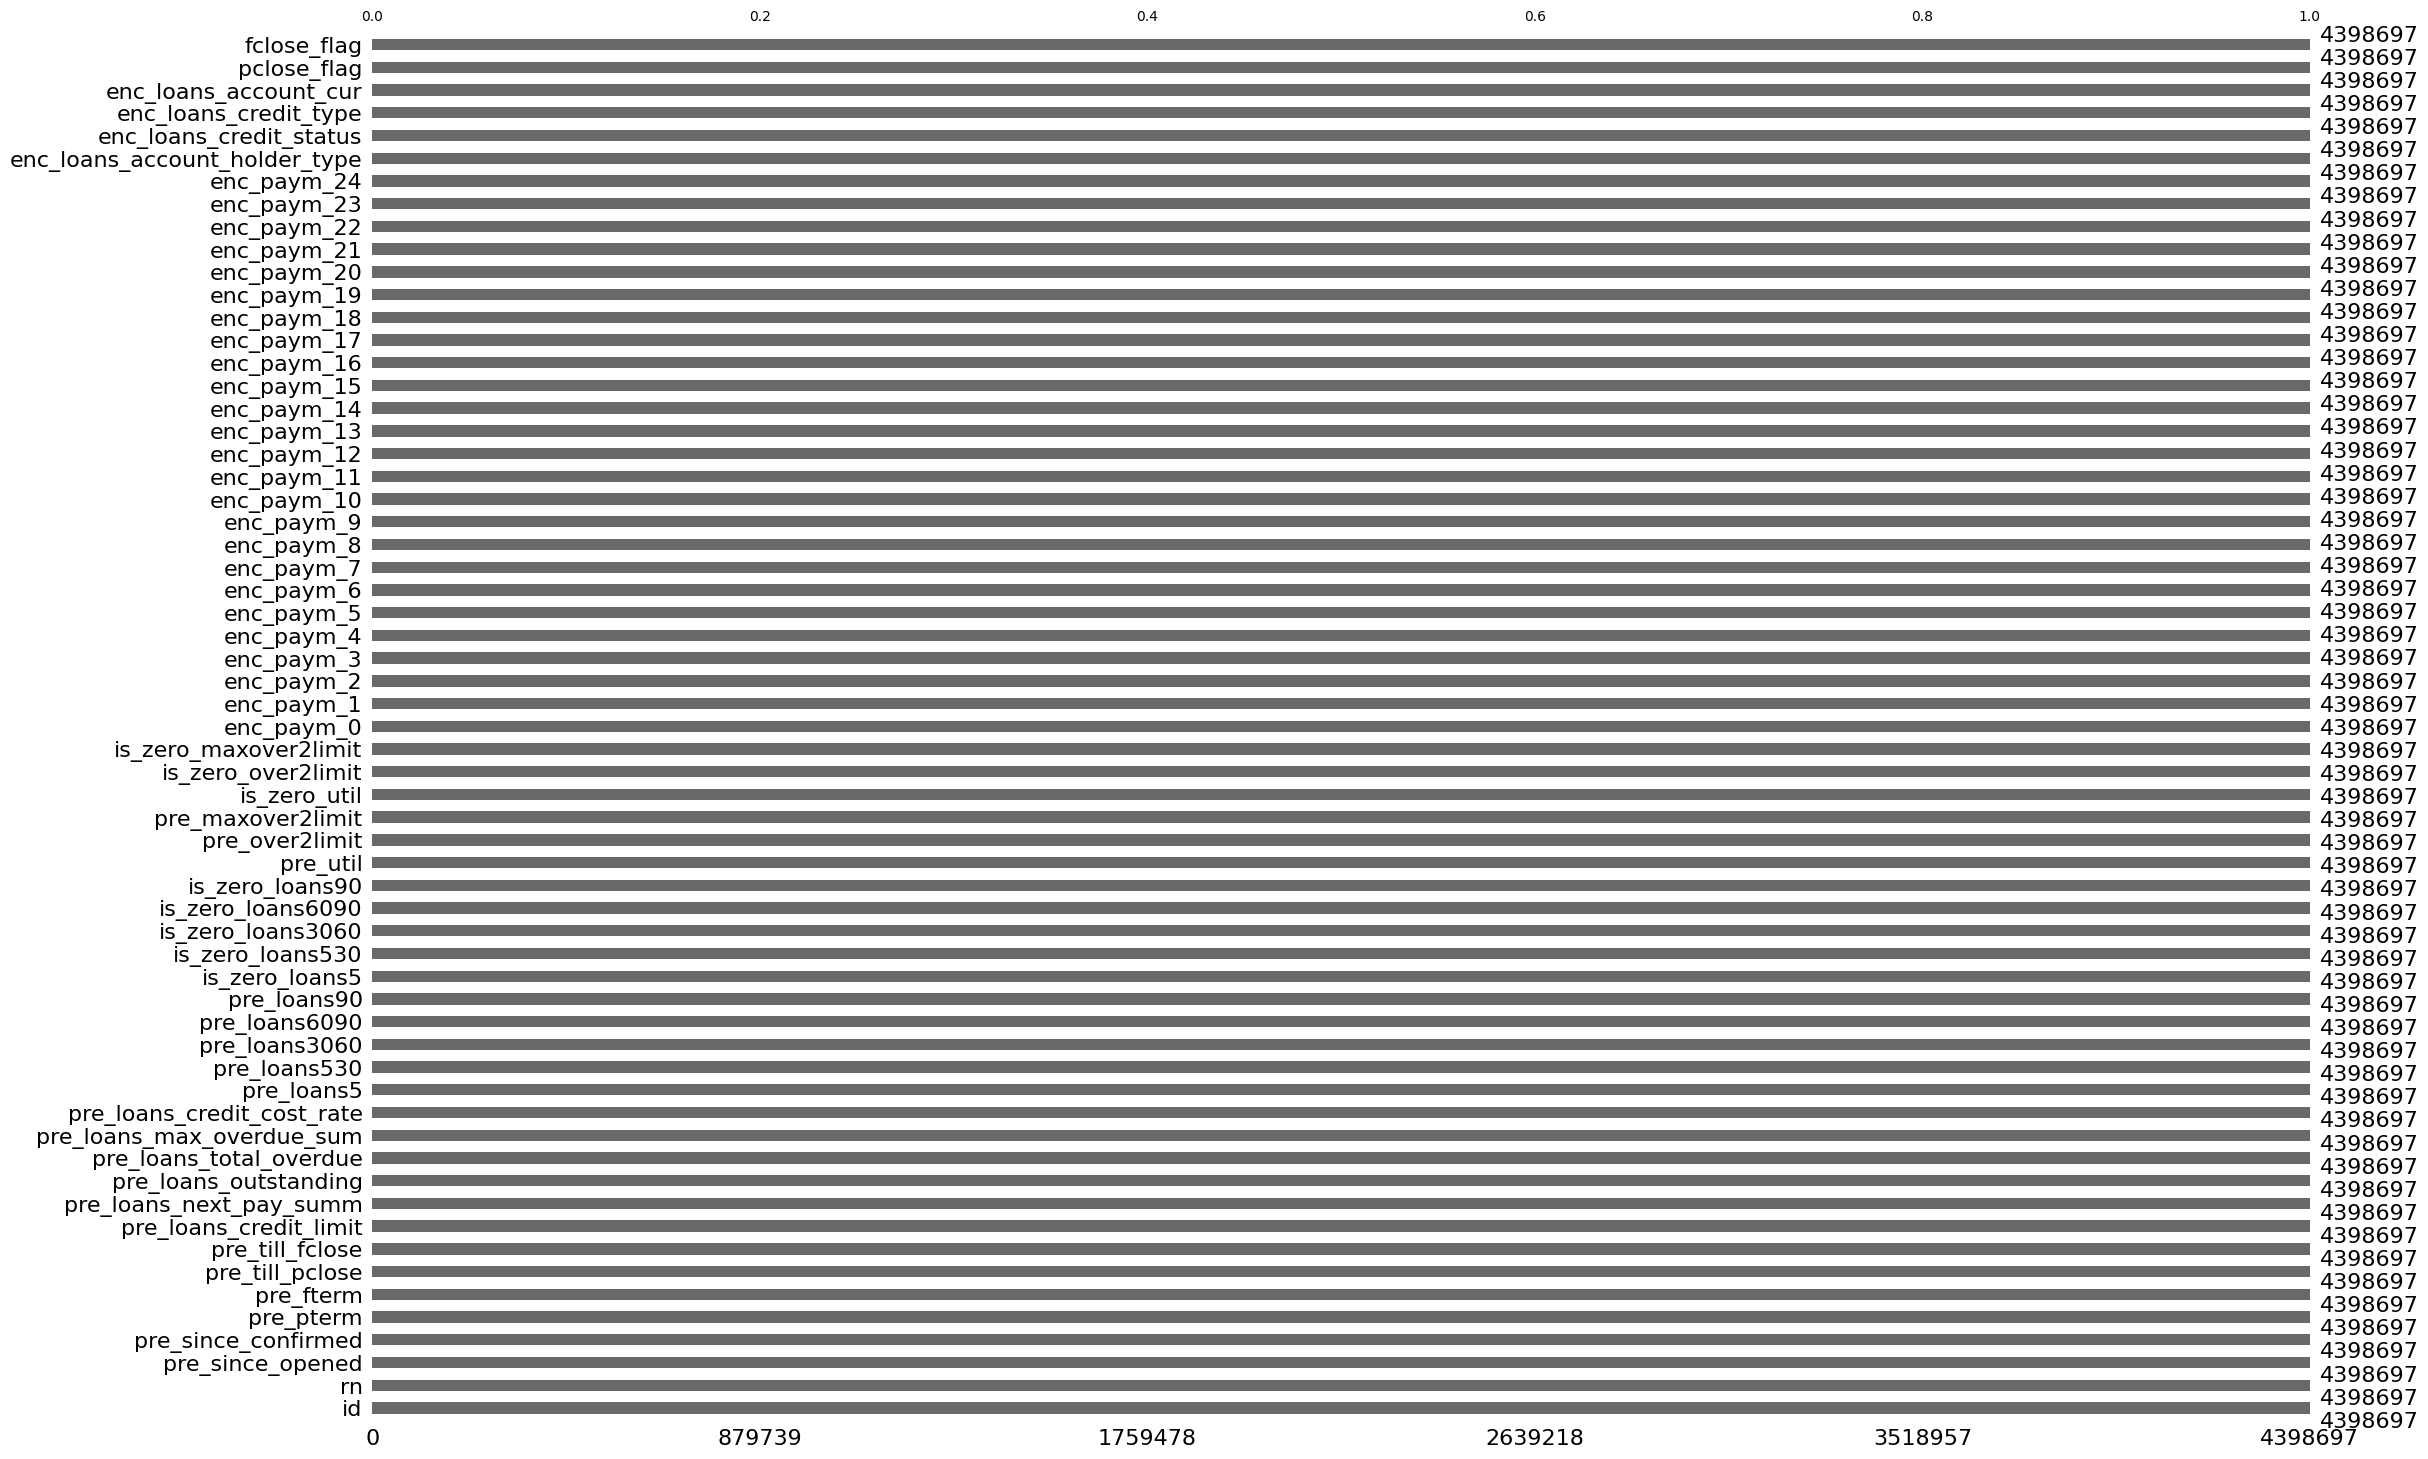

In [53]:
data = read_parquet_dataset_from_local(path, start_from=8, num_parts_to_read=2, verbose=True)
print_data_info(data)

## 8 - 9

['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']
Reading chunks:

train_data/train_data_8.pq
train_data/train_data_9.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

chunk_path train_data/train_data_8.pq
chunk_path train_data/train_data_9.pq


'=== data.shape ==='

(4526871, 61)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4526871 entries, 0 to 4526870
Data columns (total 61 columns):
 #   Column                         Dtype
---  ------                         -----
 0   id                             int64
 1   rn                             int64
 2   pre_since_opened               int64
 3   pre_since_confirmed            int64
 4   pre_pterm                      int64
 5   pre_fterm                      int64
 6   pre_till_pclose                int64
 7   pre_till_fclose                int64
 8   pre_loans_credit_limit         int64
 9   pre_loans_next_pay_summ        int64
 10  pre_loans_outstanding          int64
 11  pre_loans_total_overdue        int64
 12  pre_loans_max_overdue_sum      int64
 13  pre_loans_credit_cost_rate     int64
 14  pre_loans5                     int64
 15  pre_loans530                   int64
 16  pre_loans3060                  int64
 17  pre_loans6090                  int64
 18  pre_loans90                    int64
 19  

None

,count,mean,std,min,25%,50%,75%,max
id,4526871.0,2.251120e+06,144620.499777,2000000.0,2126126.0,2252283.0,2376841.0,2499999.0
rn,4526871.0,7.231587e+00,5.487866,1.0,3.0,6.0,10.0,49.0
pre_since_opened,4526871.0,9.419675e+00,5.824621,0.0,4.0,10.0,15.0,19.0
pre_since_confirmed,4526871.0,8.047710e+00,4.691556,0.0,4.0,9.0,11.0,17.0
pre_pterm,4526871.0,8.379583e+00,5.350037,0.0,4.0,8.0,14.0,17.0
pre_fterm,4526871.0,8.338565e+00,4.499154,0.0,6.0,8.0,12.0,16.0
pre_till_pclose,4526871.0,7.187806e+00,5.127155,0.0,2.0,7.0,12.0,16.0
pre_till_fclose,4526871.0,8.361411e+00,4.230106,0.0,5.0,10.0,11.0,15.0
pre_loans_credit_limit,4526871.0,9.634916e+00,5.839395,0.0,4.0,10.0,15.0,19.0
pre_loans_next_pay_summ,4526871.0,2.345408e+00,1.274962,0.0,2.0,2.0,2.0,6.0


,count,mean,std,min,25%,50%,75%,max
enc_paym_20,4526871.0,3.272849,1.272662,1.0,4.0,4.0,4.0,4.0
enc_paym_21,4526871.0,2.306316,1.252251,0.0,3.0,3.0,3.0,3.0
enc_paym_22,4526871.0,2.339617,1.230829,0.0,3.0,3.0,3.0,3.0
enc_paym_23,4526871.0,2.374624,1.206894,0.0,3.0,3.0,3.0,3.0
enc_paym_24,4526871.0,3.509334,1.099516,1.0,4.0,4.0,4.0,4.0
enc_loans_account_holder_type,4526871.0,1.037003,0.315928,0.0,1.0,1.0,1.0,6.0
enc_loans_credit_status,4526871.0,2.692596,0.497929,0.0,2.0,3.0,3.0,6.0
enc_loans_credit_type,4526871.0,3.611263,1.037301,0.0,3.0,4.0,4.0,7.0
enc_loans_account_cur,4526871.0,1.001529,0.045148,0.0,1.0,1.0,1.0,3.0
pclose_flag,4526871.0,0.139861,0.346843,0.0,0.0,0.0,0.0,1.0


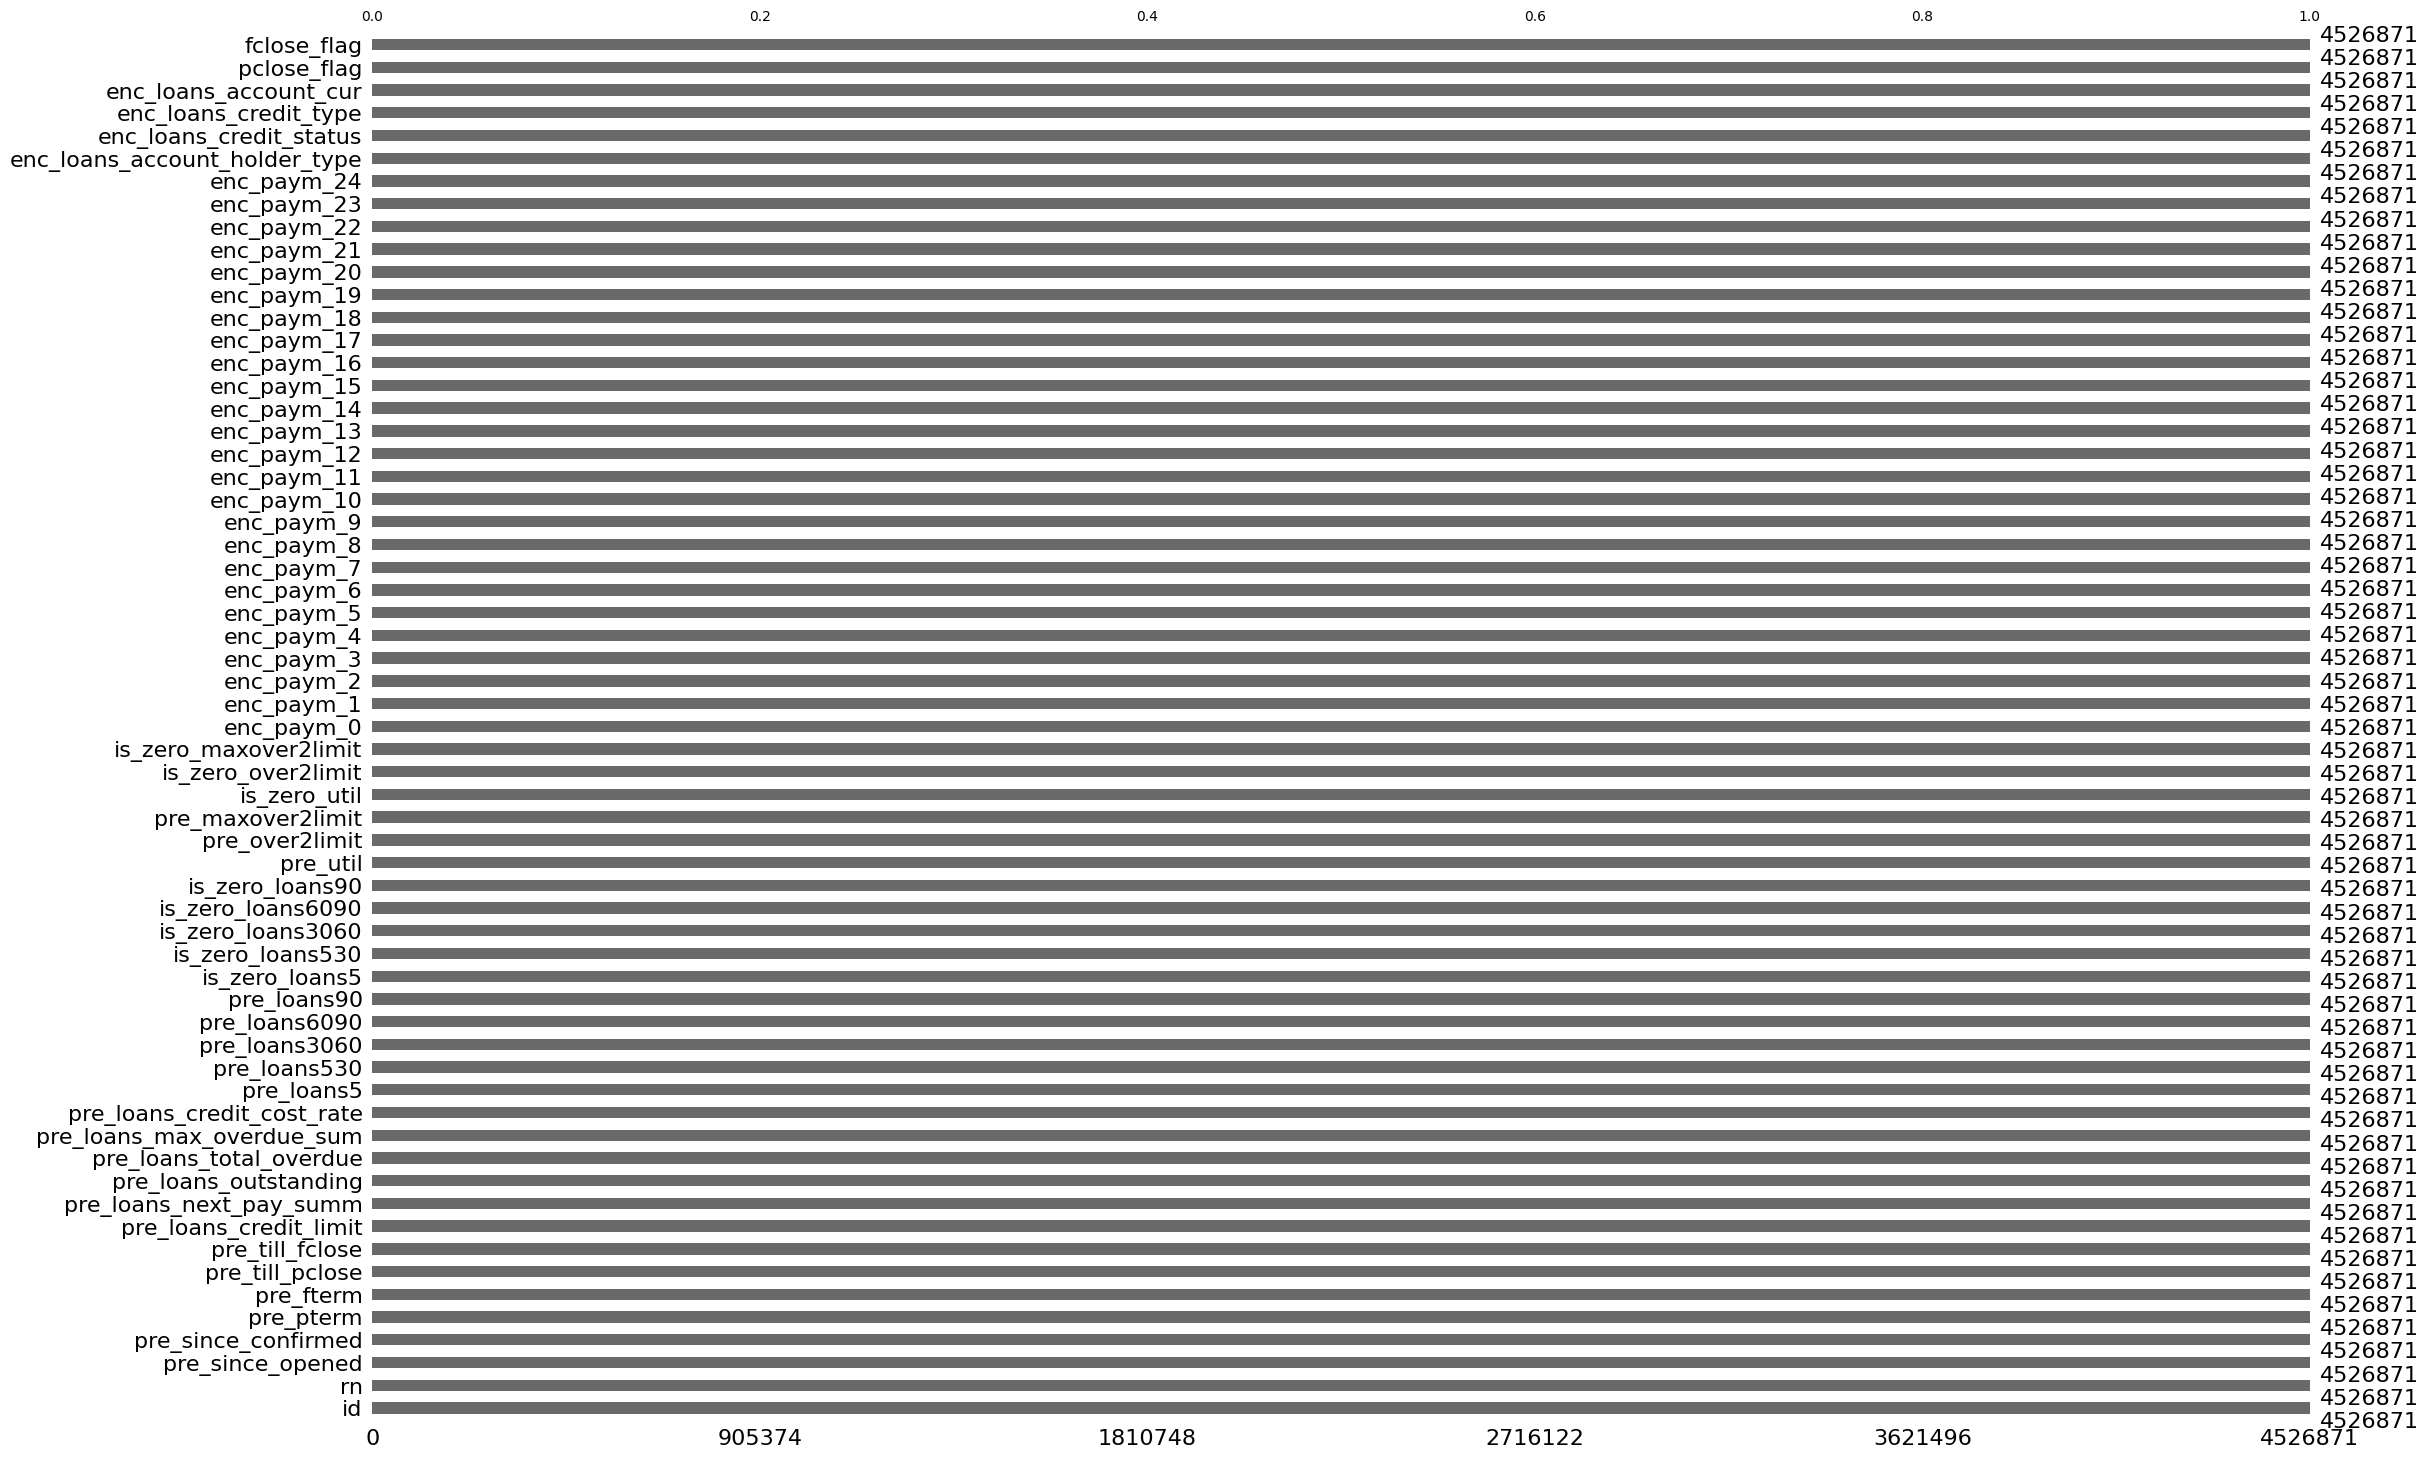

In [54]:
data = read_parquet_dataset_from_local(path, start_from=10, num_parts_to_read=2, verbose=True)
print_data_info(data)

# что дальше

['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']
Reading chunks:

train_data/train_data_11.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_11.pq


'=== data.shape ==='

(2450630, 61)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2450630 entries, 0 to 2450629
Data columns (total 61 columns):
 #   Column                         Dtype
---  ------                         -----
 0   id                             int64
 1   rn                             int64
 2   pre_since_opened               int64
 3   pre_since_confirmed            int64
 4   pre_pterm                      int64
 5   pre_fterm                      int64
 6   pre_till_pclose                int64
 7   pre_till_fclose                int64
 8   pre_loans_credit_limit         int64
 9   pre_loans_next_pay_summ        int64
 10  pre_loans_outstanding          int64
 11  pre_loans_total_overdue        int64
 12  pre_loans_max_overdue_sum      int64
 13  pre_loans_credit_cost_rate     int64
 14  pre_loans5                     int64
 15  pre_loans530                   int64
 16  pre_loans3060                  int64
 17  pre_loans6090                  int64
 18  pre_loans90                    int64
 19  

None

,count,mean,std,min,25%,50%,75%,max
id,2450630.0,2.873129e+06,71861.339233,2750000.0,2810571.0,2871226.0,2935725.0,2999999.0
rn,2450630.0,7.536719e+00,5.585190,1.0,3.0,6.0,11.0,58.0
pre_since_opened,2450630.0,9.518576e+00,5.825594,0.0,4.0,10.0,15.0,19.0
pre_since_confirmed,2450630.0,8.823944e+00,4.782442,0.0,5.0,9.0,12.0,17.0
pre_pterm,2450630.0,8.324652e+00,5.303367,0.0,4.0,8.0,14.0,17.0
pre_fterm,2450630.0,8.343988e+00,4.525760,0.0,6.0,8.0,12.0,16.0
pre_till_pclose,2450630.0,7.013055e+00,5.161085,0.0,2.0,6.0,12.0,16.0
pre_till_fclose,2450630.0,8.336912e+00,4.243316,0.0,5.0,10.0,11.0,15.0
pre_loans_credit_limit,2450630.0,9.528182e+00,5.848240,0.0,4.0,10.0,14.0,19.0
pre_loans_next_pay_summ,2450630.0,2.359488e+00,1.294435,0.0,2.0,2.0,2.0,6.0


,count,mean,std,min,25%,50%,75%,max
enc_paym_20,2450630.0,3.248850,1.287725,1.0,2.0,4.0,4.0,4.0
enc_paym_21,2450630.0,2.286148,1.265782,0.0,3.0,3.0,3.0,3.0
enc_paym_22,2450630.0,2.321148,1.243942,0.0,3.0,3.0,3.0,3.0
enc_paym_23,2450630.0,2.357841,1.219575,0.0,3.0,3.0,3.0,3.0
enc_paym_24,2450630.0,3.511694,1.098322,1.0,4.0,4.0,4.0,4.0
enc_loans_account_holder_type,2450630.0,1.036988,0.316032,0.0,1.0,1.0,1.0,6.0
enc_loans_credit_status,2450630.0,2.689747,0.490716,0.0,2.0,3.0,3.0,6.0
enc_loans_credit_type,2450630.0,3.638602,1.036298,0.0,3.0,4.0,4.0,7.0
enc_loans_account_cur,2450630.0,1.001258,0.042113,0.0,1.0,1.0,1.0,3.0
pclose_flag,2450630.0,0.167358,0.373295,0.0,0.0,0.0,0.0,1.0


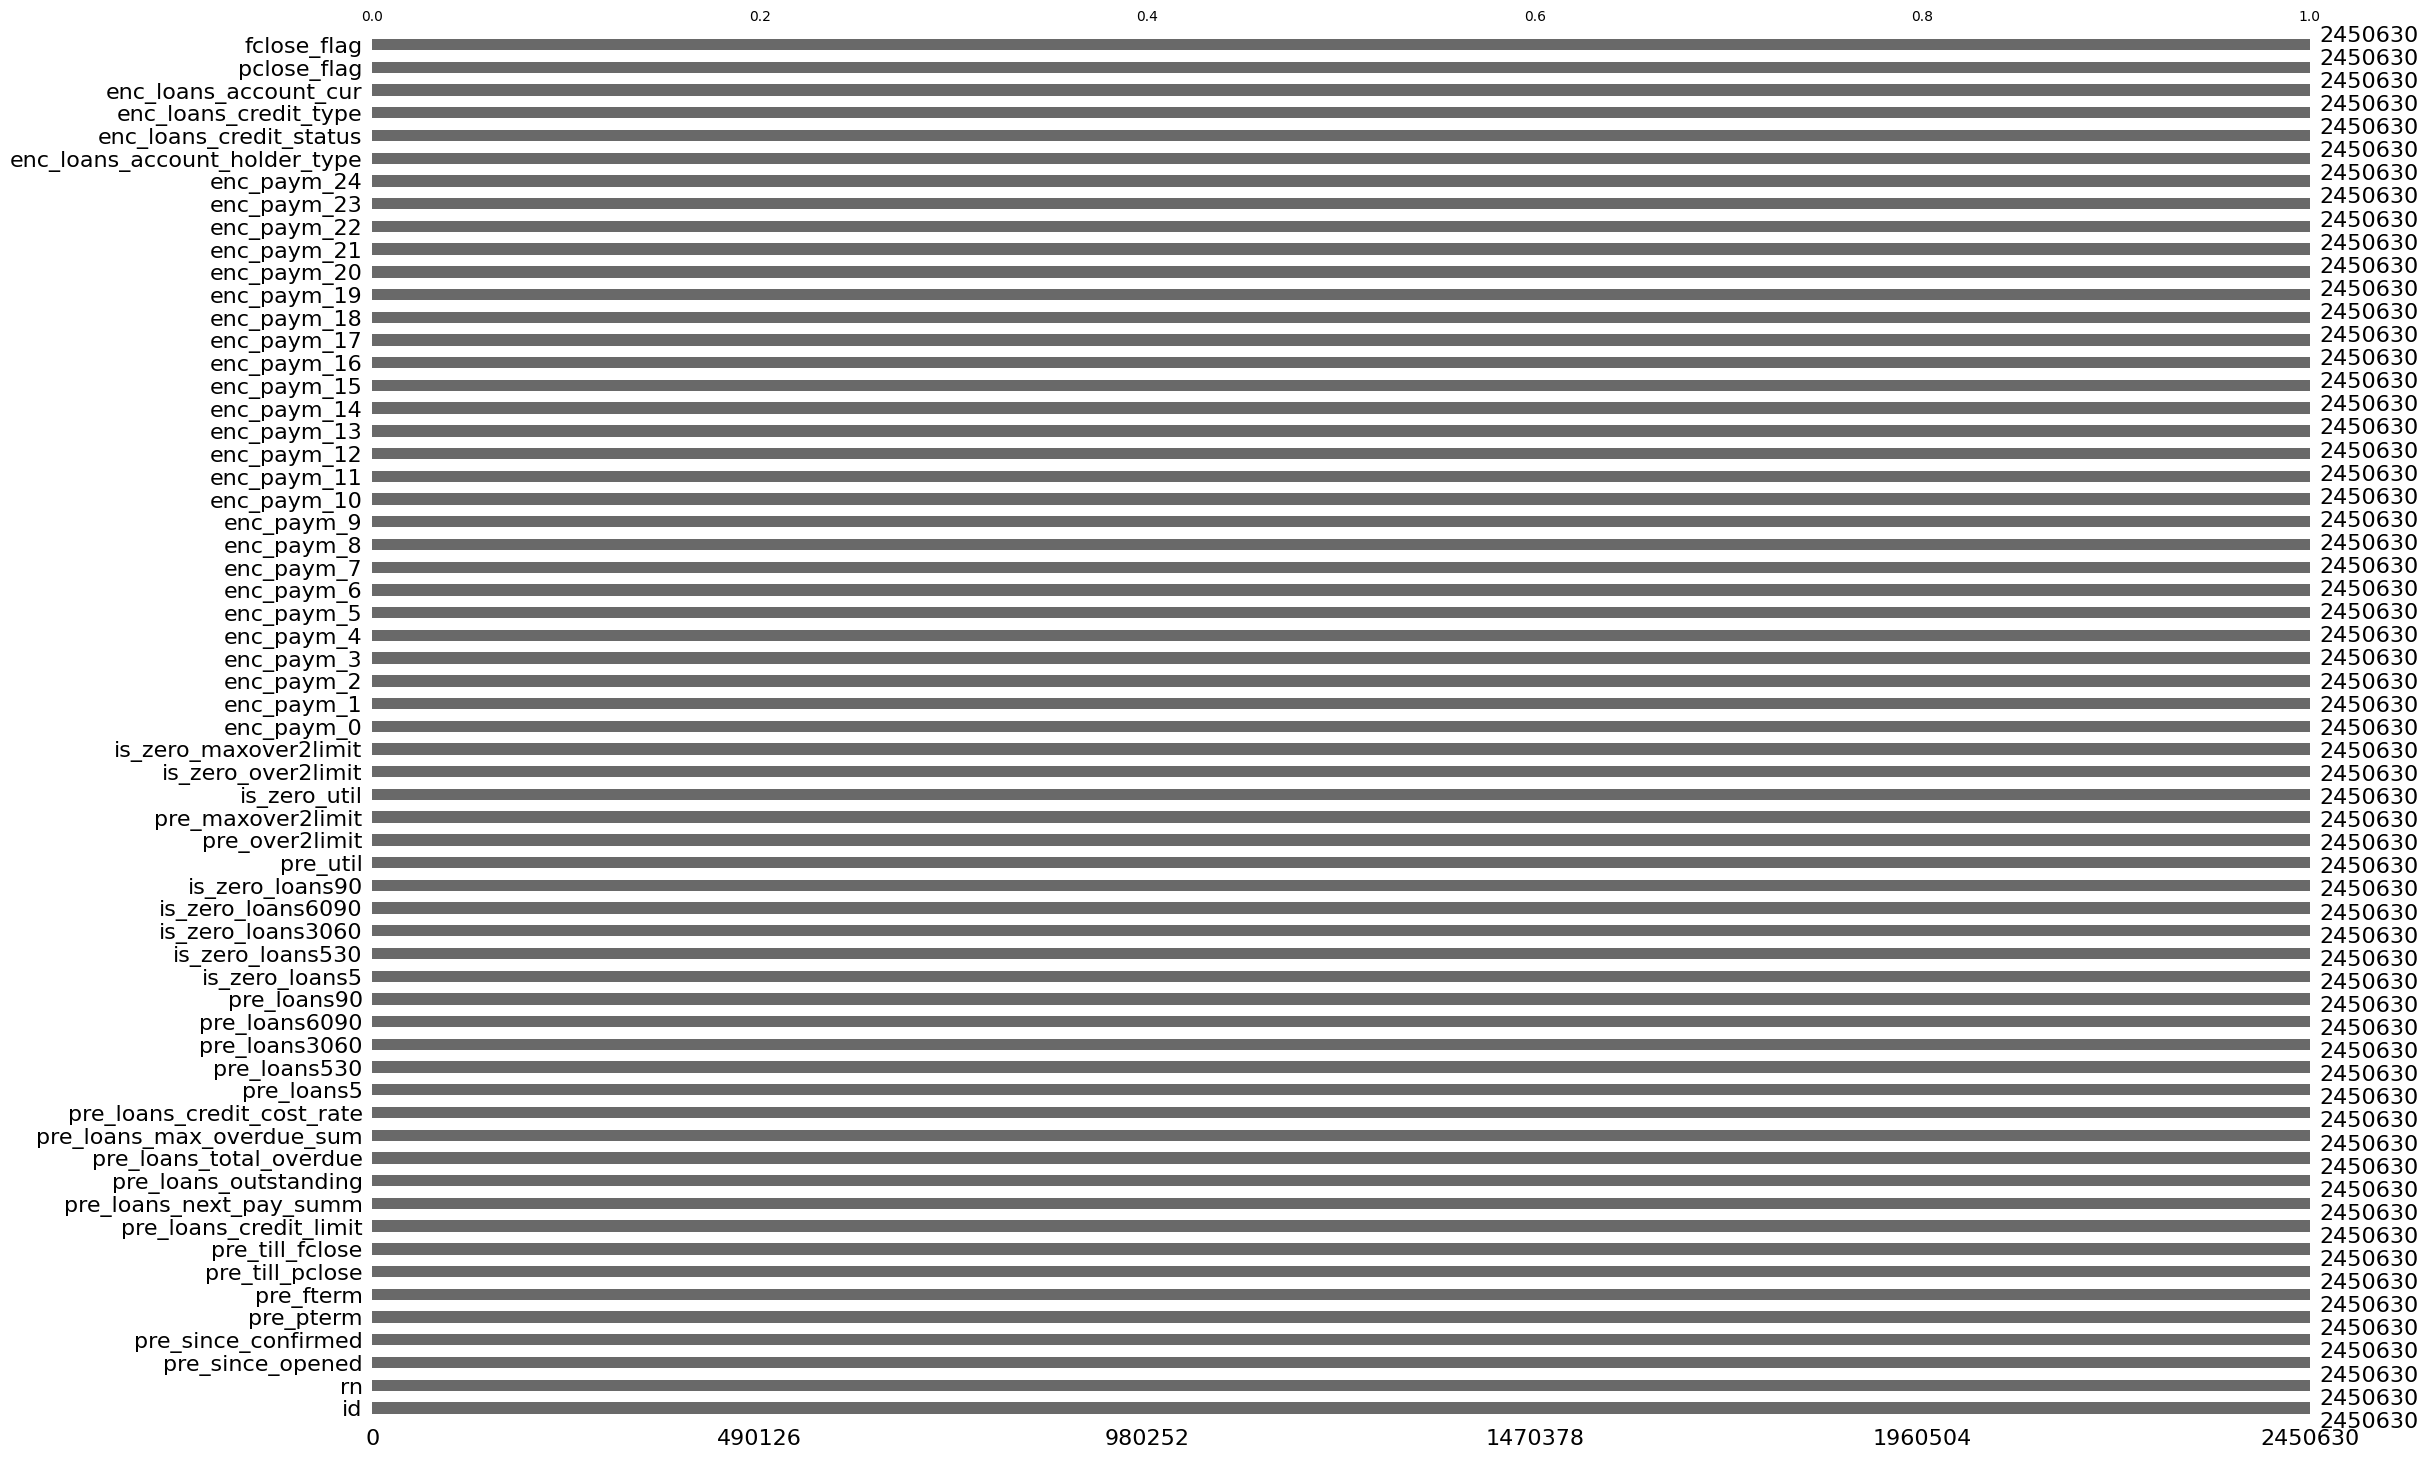

In [77]:
data = read_parquet_dataset_from_local(path, start_from=3, num_parts_to_read=1, verbose=True)
print_data_info(data)

In [78]:
columns = list(data.columns)
columns.remove('id')


In [79]:
for column in columns:
    data[column] = data[column].astype(np.int8)

'=== data.shape ==='

(2450630, 61)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2450630 entries, 0 to 2450629
Data columns (total 61 columns):
 #   Column                         Dtype
---  ------                         -----
 0   id                             int64
 1   rn                             int8 
 2   pre_since_opened               int8 
 3   pre_since_confirmed            int8 
 4   pre_pterm                      int8 
 5   pre_fterm                      int8 
 6   pre_till_pclose                int8 
 7   pre_till_fclose                int8 
 8   pre_loans_credit_limit         int8 
 9   pre_loans_next_pay_summ        int8 
 10  pre_loans_outstanding          int8 
 11  pre_loans_total_overdue        int8 
 12  pre_loans_max_overdue_sum      int8 
 13  pre_loans_credit_cost_rate     int8 
 14  pre_loans5                     int8 
 15  pre_loans530                   int8 
 16  pre_loans3060                  int8 
 17  pre_loans6090                  int8 
 18  pre_loans90                    int8 
 19  

None

,count,mean,std,min,25%,50%,75%,max
id,2450630.0,2.873129e+06,71861.339233,2750000.0,2810571.0,2871226.0,2935725.0,2999999.0
rn,2450630.0,7.536719e+00,5.585190,1.0,3.0,6.0,11.0,58.0
pre_since_opened,2450630.0,9.518576e+00,5.825594,0.0,4.0,10.0,15.0,19.0
pre_since_confirmed,2450630.0,8.823944e+00,4.782442,0.0,5.0,9.0,12.0,17.0
pre_pterm,2450630.0,8.324652e+00,5.303367,0.0,4.0,8.0,14.0,17.0
pre_fterm,2450630.0,8.343988e+00,4.525760,0.0,6.0,8.0,12.0,16.0
pre_till_pclose,2450630.0,7.013055e+00,5.161085,0.0,2.0,6.0,12.0,16.0
pre_till_fclose,2450630.0,8.336912e+00,4.243316,0.0,5.0,10.0,11.0,15.0
pre_loans_credit_limit,2450630.0,9.528182e+00,5.848240,0.0,4.0,10.0,14.0,19.0
pre_loans_next_pay_summ,2450630.0,2.359488e+00,1.294435,0.0,2.0,2.0,2.0,6.0


,count,mean,std,min,25%,50%,75%,max
enc_paym_20,2450630.0,3.248850,1.287725,1.0,2.0,4.0,4.0,4.0
enc_paym_21,2450630.0,2.286148,1.265782,0.0,3.0,3.0,3.0,3.0
enc_paym_22,2450630.0,2.321148,1.243942,0.0,3.0,3.0,3.0,3.0
enc_paym_23,2450630.0,2.357841,1.219575,0.0,3.0,3.0,3.0,3.0
enc_paym_24,2450630.0,3.511694,1.098322,1.0,4.0,4.0,4.0,4.0
enc_loans_account_holder_type,2450630.0,1.036988,0.316032,0.0,1.0,1.0,1.0,6.0
enc_loans_credit_status,2450630.0,2.689747,0.490716,0.0,2.0,3.0,3.0,6.0
enc_loans_credit_type,2450630.0,3.638602,1.036298,0.0,3.0,4.0,4.0,7.0
enc_loans_account_cur,2450630.0,1.001258,0.042113,0.0,1.0,1.0,1.0,3.0
pclose_flag,2450630.0,0.167358,0.373295,0.0,0.0,0.0,0.0,1.0


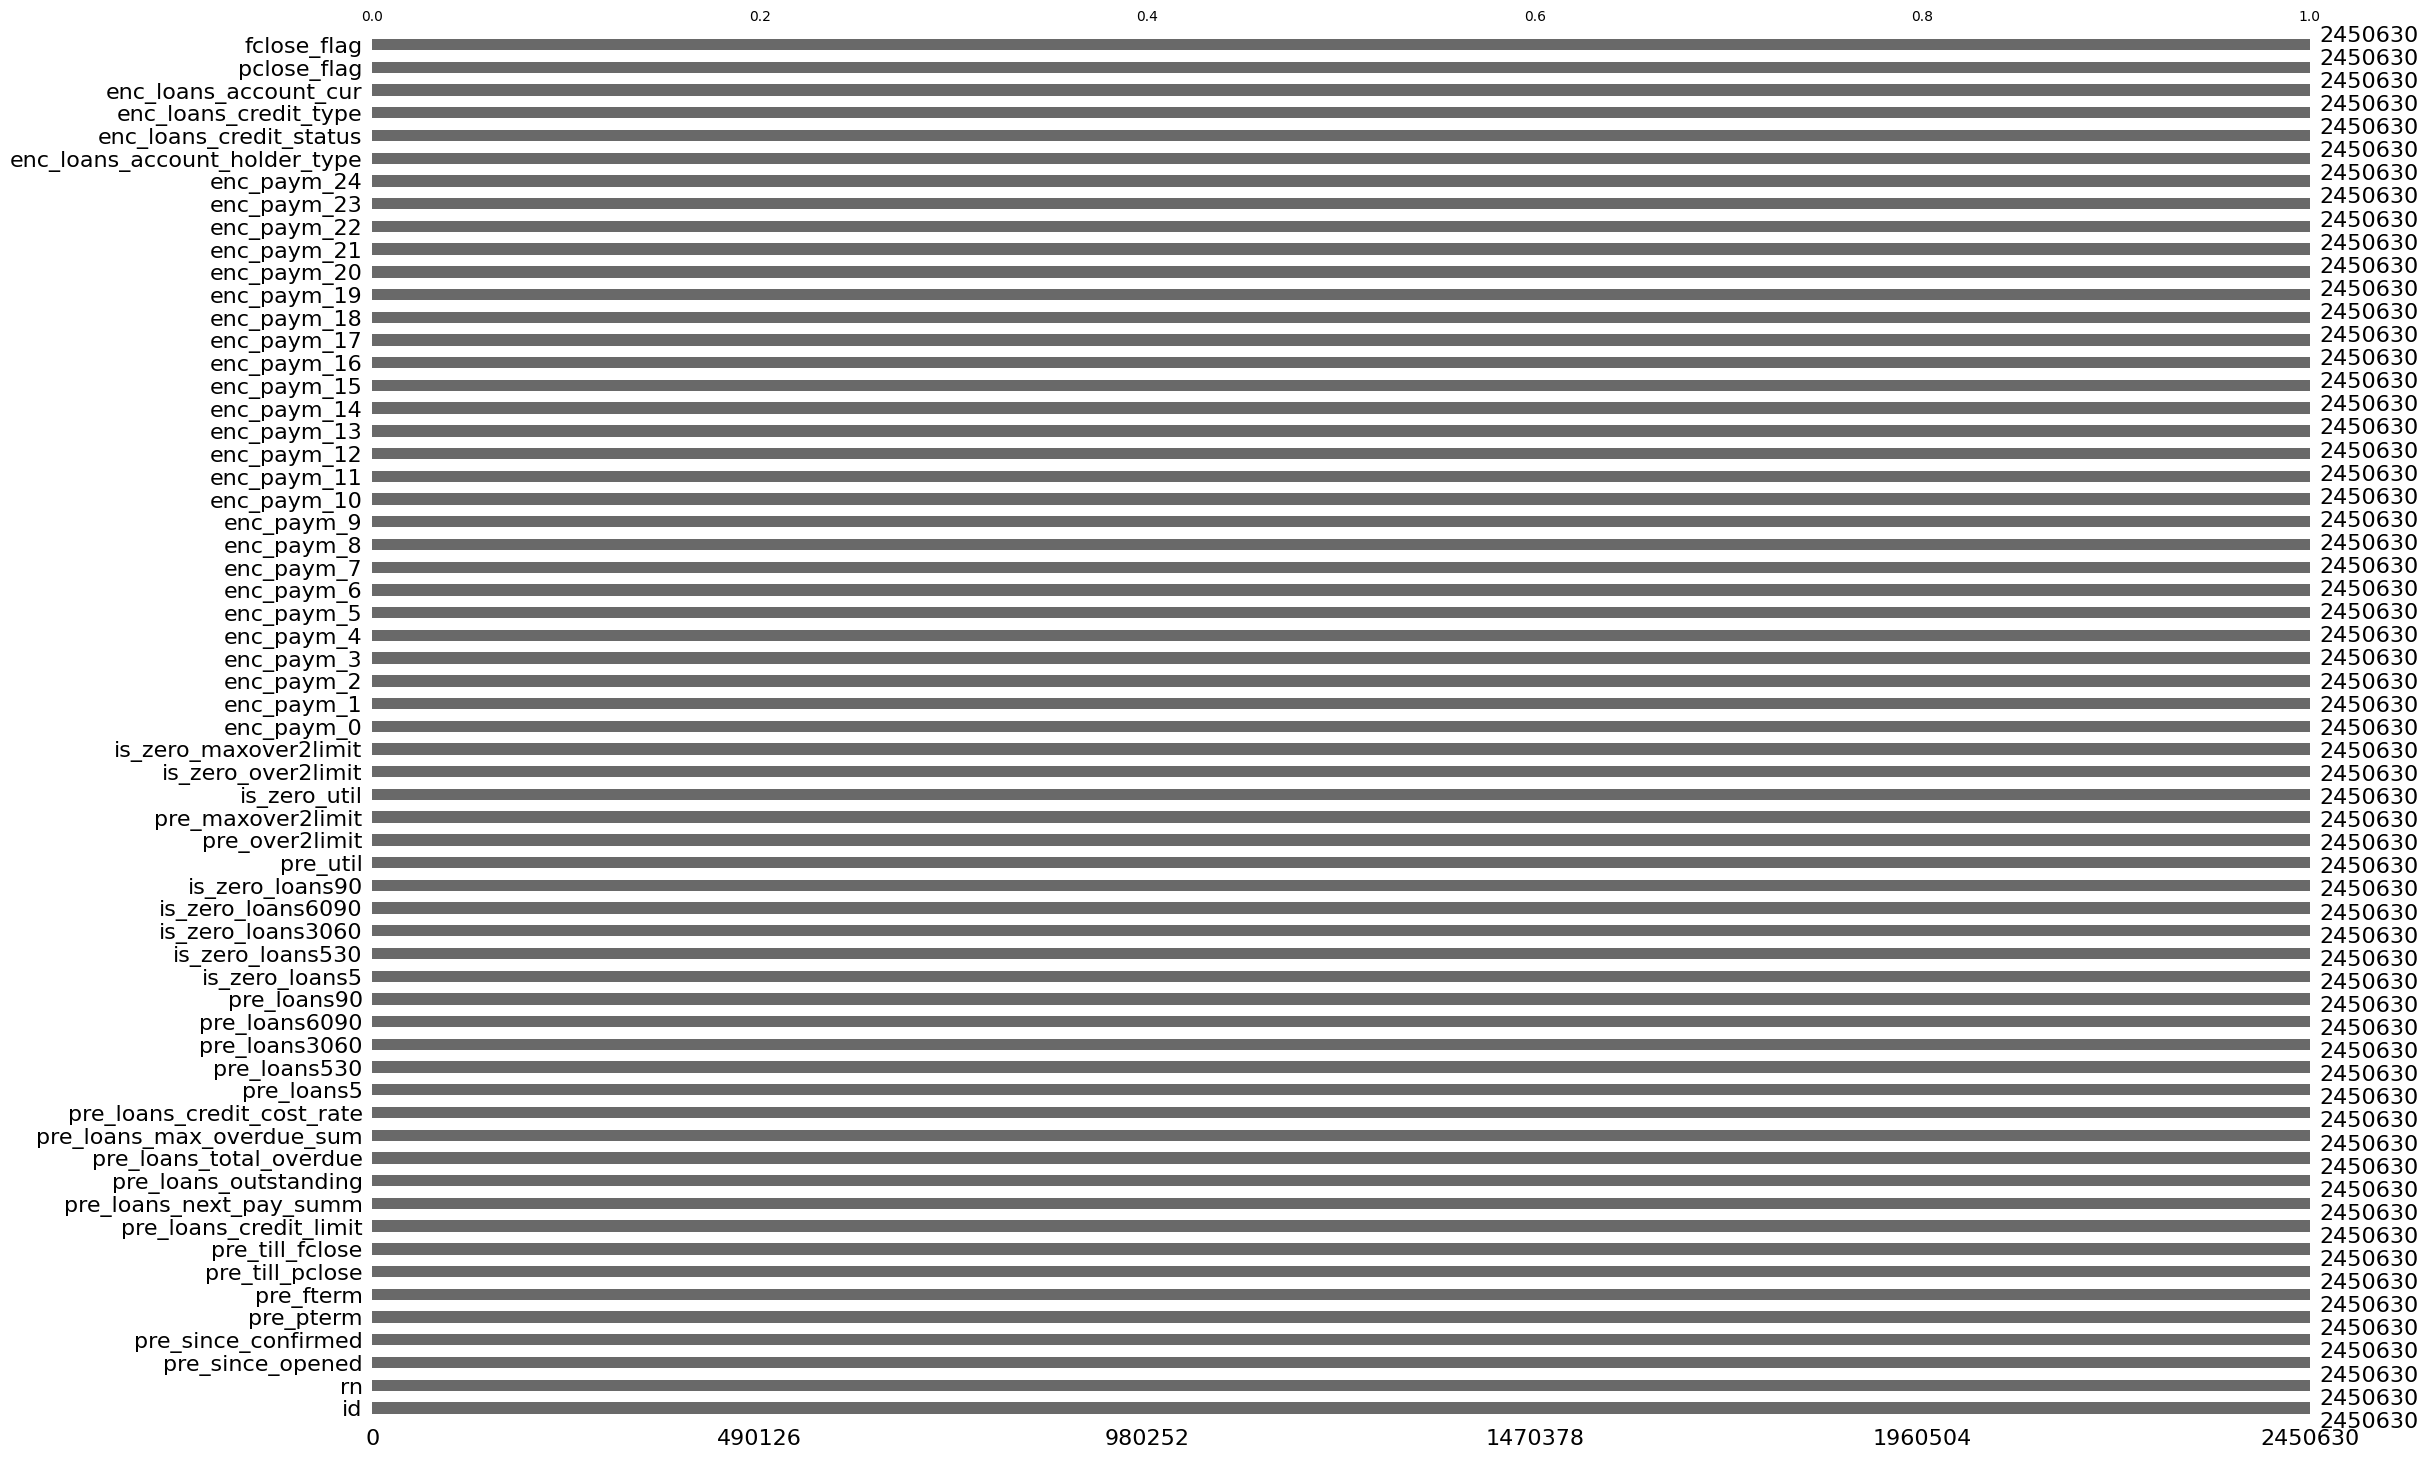

In [80]:
print_data_info(data)

<Axes: >

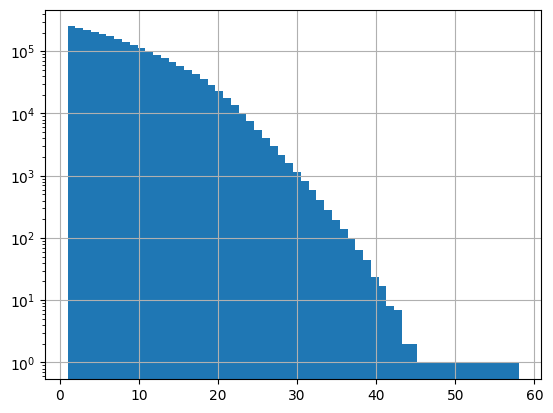

In [83]:
data.rn.hist(bins=58, log=True)

In [84]:
data

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
0,2750000,1,2,2,2,14,12,11,3,6,...,3,3,3,4,1,2,4,1,0,0
1,2750000,2,1,2,14,7,10,8,10,1,...,3,3,3,4,1,2,3,1,0,0
2,2750000,3,9,2,4,8,1,11,14,2,...,3,3,3,4,1,2,3,1,1,1
3,2750000,4,9,2,11,16,14,8,9,3,...,3,3,3,4,1,2,4,1,0,0
4,2750000,5,9,2,6,1,0,4,4,2,...,3,3,3,4,1,2,3,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2450625,2999999,8,6,5,14,13,1,15,16,2,...,0,0,0,1,1,3,4,1,0,0
2450626,2999999,9,5,3,2,10,15,14,17,2,...,0,0,0,4,1,3,4,1,0,0
2450627,2999999,10,3,16,11,13,14,8,15,5,...,0,0,3,4,1,2,4,1,0,0
2450628,2999999,11,3,6,4,8,1,11,0,5,...,3,3,3,4,1,2,3,1,1,1


In [85]:
data.set_index(['id', 'rn'], inplace=False)

pre_since_opened  pre_since_confirmed  pre_pterm  pre_fterm   
id      rn                                                                
2750000 1                  2                    2          2         14  \
        2                  1                    2         14          7   
        3                  9                    2          4          8   
        4                  9                    2         11         16   
        5                  9                    2          6          1   
...                      ...                  ...        ...        ...   
2999999 8                  6                    5         14         13   
        9                  5                    3          2         10   
        10                 3                   16         11         13   
        11                 3                    6          4          8   
        12                 2                    2          2         14   

            pre_till_pclose  pre_till_fclose  pre_loans_credit_limit   
id      rn                                                             
2750000 1                12               11                       3  \
        2                10                8                      10   
        3                 1               11                      14   
        4                14                8                       9   
        5                 0                4                       4   
...                     ...              ...                     ...   
2999999 8                 1               15                      16   
        9                15               14                      17   
        10               14                8                      15   
        11                1               11                       0   
        12               12               11                      10   

            pre_loans_next_pay_summ  pre_loans_outstanding   
id      rn                                                   
2750000 1                         6                      3  \
        2                         1                      2   
        3                         2                      3   
        4                         3                      5   
        5                         2                      3   
...                             ...                    ...   
2999999 8                         2                      3   
        9                         2                      3   
        10                        5                      1   
        11                        5                      1   
        12                        1                      4   

            pre_loans_total_overdue  ...  enc_paym_21  enc_paym_22   
id      rn                           ...                             
2750000 1                         0  ...            3            3  \
        2                         0  ...            3            3   
        3                         0  ...            3            3   
        4                         0  ...            3            3   
        5                         0  ...            3            3   
...                             ...  ...          ...          ...   
2999999 8                         0  ...            0            0   
        9                         0  ...            0            0   
        10                        0  ...            0            0   
        11                        0  ...            3            3   
        12                        0  ...            3            3   

            enc_paym_23  enc_paym_24  enc_loans_account_holder_type   
id      rn                                                            
2750000 1             3            4                              1  \
        2             3            4                              1   
        3             3            4                              1   
        4             3   

In [ ]:
df.stack().unstack([-2,-1]).rename_axis((None, None), axis=1)

In [86]:
data.set_index(['id', 'rn'], inplace=False).stack().unstack([-2,-1]).rename_axis((None, None), axis=1)

1                                            
        pre_since_opened pre_since_confirmed pre_pterm pre_fterm   
id                                                                 
2750000              2.0                 2.0       2.0      14.0  \
2750001             15.0                17.0       7.0       2.0   
2750002              1.0                16.0       2.0       8.0   
2750003             10.0                 4.0       6.0       8.0   
2750004              0.0                17.0       9.0      12.0   
...                  ...                 ...       ...       ...   
2999995             15.0                 4.0      17.0      16.0   
2999996             16.0                 8.0      16.0      15.0   
2999997              4.0                 8.0       7.0       6.0   
2999998              4.0                11.0       4.0      15.0   
2999999             16.0                17.0       7.0       2.0   

                                                                 
        pre_till_pclose pre_till_fclose pre_loans_credit_limit   
id                                                               
2750000            12.0            11.0                    3.0  \
2750001             9.0             1.0                    5.0   
2750002            12.0            11.0                    7.0   
2750003             0.0            11.0                   10.0   
2750004            13.0             5.0                    3.0   
...                 ...             ...                    ...   
2999995            13.0             3.0                   14.0   
2999996             4.0             9.0                   13.0   
2999997             5.0             7.0                   17.0   
2999998             1.0            12.0                    4.0   
2999999             4.0             9.0                    5.0   

                                                                                
        pre_loans_next_pay_summ pre_loans_outstanding pre_loans_total_overdue   
id                                                                              
2750000                     6.0                   3.0                     0.0  \
2750001                     2.0                   3.0                     0.0   
2750002                     3.0                   2.0                     0.0   
2750003                     2.0                   3.0                     0.0   
2750004                     2.0                   3.0                     0.0   
...                         ...                   ...                     ...   
2999995                     2.0                   3.0                     0.0   
2999996                     2.0                   3.0                     0.0   
2999997                     2.0                   3.0                     0.0   
2999998                     2.0                   3.0                     0.0   
2999999                     2.0                   3.0                     0.0   

         ...          58                                       
         ... enc_paym_21 enc_paym_22 enc_paym_23 enc_paym_24   
id       ...                                                   
2750000  ...         NaN         NaN         NaN         NaN  \
2750001  ...         NaN         NaN         NaN         NaN   
2750002  ...         NaN         NaN         NaN         NaN   
2750003  ...         NaN         NaN         NaN         NaN   
2750004  ...         NaN         NaN         NaN         NaN   
...      ...         ...         ...         ...         ...   
2999995  ...         NaN         NaN         NaN         NaN   
2999996  ...         NaN         NaN         NaN         NaN   
2999997  ...         NaN         NaN         NaN         NaN   
2999998  ...         NaN         NaN         NaN         NaN   
2999999  ...         NaN         NaN         NaN         NaN   

                                                                
        enc_loans_account_holder_type enc_loans

## возвращение

In [14]:
data = prepare_transactions_dataset(path_to_dataset=path, 
                                    num_parts_to_preprocess_at_once = 1, 
                                    num_parts_total=12,
                                    save_to_path=None, 
                                    verbose=True)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_6340\2668831860.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm.tqdm_notebook(range(0, num_parts_total, num_parts_to_preprocess_at_once),


Transforming transactions data:   0%|          | 0/12 [00:00<?, ?it/s]

['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']
Reading chunks:

train_data/train_data_0.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_0.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']
Reading chunks:

train_data/train_data_1.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_1.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']
Reading chunks:

train_data/train_data_10.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_10.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']
Reading chunks:

train_data/train_data_11.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_11.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']
Reading chunks:

train_data/train_data_2.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_2.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']
Reading chunks:

train_data/train_data_3.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_3.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']
Reading chunks:

train_data/train_data_4.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_4.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']
Reading chunks:

train_data/train_data_5.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_5.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']
Reading chunks:

train_data/train_data_6.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_6.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']
Reading chunks:

train_data/train_data_7.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_7.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']
Reading chunks:

train_data/train_data_8.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_8.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']
Reading chunks:

train_data/train_data_9.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_9.pq


In [15]:
data.columns

Index(['id', 'rn', 'pre_since_opened', 'pre_since_confirmed', 'pre_pterm',
       'pre_fterm', 'pre_till_pclose', 'pre_till_fclose',
       'pre_loans_credit_limit', 'pre_loans_next_pay_summ',
       'pre_loans_outstanding', 'pre_loans_total_overdue',
       'pre_loans_max_overdue_sum', 'pre_loans_credit_cost_rate', 'pre_loans5',
       'pre_loans530', 'pre_loans3060', 'pre_loans6090', 'pre_loans90',
       'is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060',
       'is_zero_loans6090', 'is_zero_loans90', 'pre_util', 'pre_over2limit',
       'pre_maxover2limit', 'is_zero_util', 'is_zero_over2limit',
       'is_zero_maxover2limit', 'enc_paym_0', 'enc_paym_1', 'enc_paym_2',
       'enc_paym_3', 'enc_paym_4', 'enc_paym_5', 'enc_paym_6', 'enc_paym_7',
       'enc_paym_8', 'enc_paym_9', 'enc_paym_10', 'enc_paym_11', 'enc_paym_12',
       'enc_paym_13', 'enc_paym_14', 'enc_paym_15', 'enc_paym_16',
       'enc_paym_17', 'enc_paym_18', 'enc_paym_19', 'enc_paym_20',
       'enc_paym_21', 

In [17]:
data['rn'].max()

58

<Axes: >

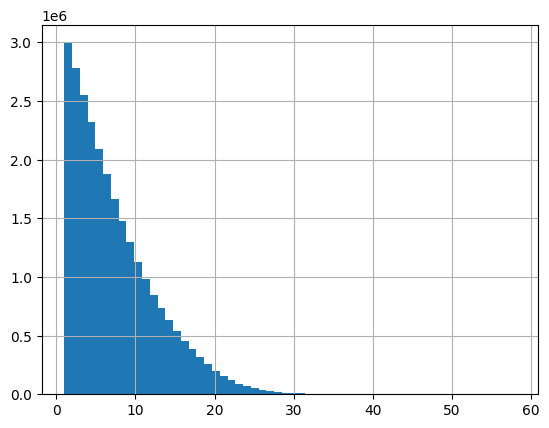

In [18]:
data['rn'].hist(bins=58)

In [26]:
q3 = np.percentile(data['rn'], 75)
q3

10.0

In [27]:
q1 = np.percentile(data['rn'], 25)
q1

3.0

In [53]:
max_rn_count = int(q3 + 1.5*(q3 - q1))
max_rn_count

20

In [31]:
df_for_rn = data.groupby(by='id').agg({'rn': 'max'})

In [32]:
df_for_rn

,rn
id,
0,10
1,14
2,3
3,15
4,1
...,...
2999995,11
2999996,13
2999997,10


In [46]:
max_rn = data['id'].apply(lambda x: df_for_rn.values[x][0])

In [49]:
max_rn = max_rn.astype(np.int8)
max_rn

0          10
1          10
2          10
3          10
4          10
           ..
2284251    15
2284252    15
2284253    15
2284254    15
2284255    15
Name: id, Length: 26162717, dtype: int8

In [48]:
data

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
0,0,1,18,9,2,3,16,10,11,3,...,3,3,3,4,1,3,4,1,0,0
1,0,2,18,9,14,14,12,12,0,3,...,0,0,0,4,1,3,4,1,0,0
2,0,3,18,9,4,8,1,11,11,0,...,0,0,0,4,1,2,3,1,1,1
3,0,4,4,1,9,12,16,7,12,2,...,3,3,3,4,1,3,1,1,0,0
4,0,5,5,12,15,2,11,12,10,2,...,3,3,3,4,1,3,4,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2284251,2499999,11,3,9,4,3,1,12,6,2,...,3,3,3,4,1,3,4,1,1,0
2284252,2499999,12,3,9,1,15,12,6,9,3,...,3,3,3,4,1,3,4,1,0,0
2284253,2499999,13,2,9,4,8,1,11,7,3,...,3,3,3,4,1,2,3,1,1,1
2284254,2499999,14,2,9,4,9,1,15,16,2,...,3,3,3,4,1,3,4,1,1,0


In [ ]:
data['max_rn'] = max_rn

In [50]:
data['rn'] = max_rn - data['rn']

In [54]:
data = data[data['rn'] < max_rn_count]

In [55]:
data.shape

(25537912, 61)

In [56]:
data.to_pickle(path='last_data.pkl')

# Foot